In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.io import ascii, fits
#from astropy.wcs import WCS, utils
#from astropy.table import Table
#from astropy.stats import knuth_bin_width, histogram, bayesian_blocks
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
#import lmfit
import pandas as pd
#from ipywidgets import FloatProgress
from IPython.display import display
from MUSE_Models import MUSE_3D_OIII, MUSE_3D_residual, PNextractor, PSF_residuals, data_cube_y_x, Gaussian_1D_res
#import corner
%config InlineBackend.figure_format = 'retina'

In [2]:
# functions
# Open Fits file and assign to raw_data
hdulist = fits.open("FCC277_data/FCC277_emission_cube.fits")
hdr = hdulist[0].header
raw_data = hdulist[0].data
raw_data_list = raw_data#[:,382:543]
short_raw_data_list = raw_data[:,382:543]

y_data, x_data, n_data = data_cube_y_x(len(raw_data))
#y_data = 442 #hdr["NAXIS2"]
#x_data = 449 #hdr["NAXIS1"]

full_wavelength = np.load("exported_data/FCC277/wavelength.npy") #np.exp(hdr['CRVAL3']+np.arange(hdr["NAXIS3"])*hdr['CDELT3'])
wavelength = full_wavelength[382:543]

raw_data_cube = raw_data_list.reshape(y_data, x_data, len(full_wavelength))

#Read in x and y coordinates
x_y_list = np.load("exported_data/FCC277/sep_x_y_list.npy")
x_PNe = np.array([x[0] for x in x_y_list])
y_PNe = np.array([y[1] for y in x_y_list])

n_pixels= 11
z = 0.00547
c = 299792458.0
D = 20.5

coordinates = [(n,m) for n in range(n_pixels) for m in range(n_pixels)]
x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])

# Retrieve the respective spectra for each PNe source
PNe_spectra = np.array([PNextractor(x, y, n_pixels, raw_data_cube, wave=full_wavelength, dim=2.0) for x,y in zip(x_PNe, y_PNe)])

# create Pandas data frame for values
PNe_df = pd.DataFrame(columns=("PNe number", "Ra (J2000)", "Dec (J2000)", "[OIII] Flux", "[OIII]/Hb", "Flux error", "V (km/s)", "m 5007", "M 5007", "M 5007 error","A/rN", "rad D"))
PNe_df["PNe number"] = np.arange(0,len(x_PNe)) # PNe numbers
#PNe_df["rad D"] = [np.sqrt((x-x_data/2.)**2 + (y - y_data/2.)**2) for x,y in zip(x_PNe, y_PNe)] # Radial distance, in pixels, from the centre of pointing
# .loc(Row, column name)

# Ra and Dec
#hdu_wcs = fits.open("FCC167_data/FCC167_center_DATACUBE_CLEANED.fits")
#hdr_wcs = hdu_wcs[1].header
#wcs_obj = WCS(hdr_wcs, naxis=2)

#for i in np.arange(0, len(x_PNe)):
#    Ra_Dec = utils.pixel_to_skycoord(x_PNe[i],y_PNe[i], wcs_obj).to_string("hmsdms").split()
#    PNe_df.loc[i,"Ra (J2000)"] = Ra_Dec[0]
#    PNe_df.loc[i,"Dec (J2000)"] = Ra_Dec[1]

#Objective Residual Cube
obj_residual_cube = np.load("exported_data/FCC277/list_of_resids_min_obj.npy")

# Data Residual Cube
residual_cube = np.load("exported_data/FCC277/list_of_resids_min.npy")

def uncertainty_cube_construct(data, x_P, y_P, n_pix):
    data[data == np.inf] = 0.01
    data_shape = data.reshape(y_data, x_data, len(full_wavelength))
    extract_data = np.array([PNextractor(x, y, n_pix, data_shape, wave=full_wavelength, dim=2) for x,y in zip(x_P, y_P)])
    array_to_fill = np.zeros((len(x_P), n_pix*n_pix, len(full_wavelength)))
    for p in np.arange(0, len(x_P)):
        list_of_std = [np.abs(np.std(spec)) for spec in extract_data[p]]
        array_to_fill[p] = [np.repeat(list_of_std[i], len(full_wavelength)) for i in np.arange(0, len(list_of_std))]
  
    return array_to_fill

error_cube = uncertainty_cube_construct(residual_cube, x_PNe, y_PNe, n_pixels)
obj_error_cube = uncertainty_cube_construct(obj_residual_cube, x_PNe, y_PNe, n_pixels)

In [25]:
gandalf_emission = fits.open("FCC277_data/FCC277_Gandalf_fit_emission-002.fits")
gandalf_cube = np.array(gandalf_emission[0].data).reshape(y_data, x_data, len(full_wavelength))

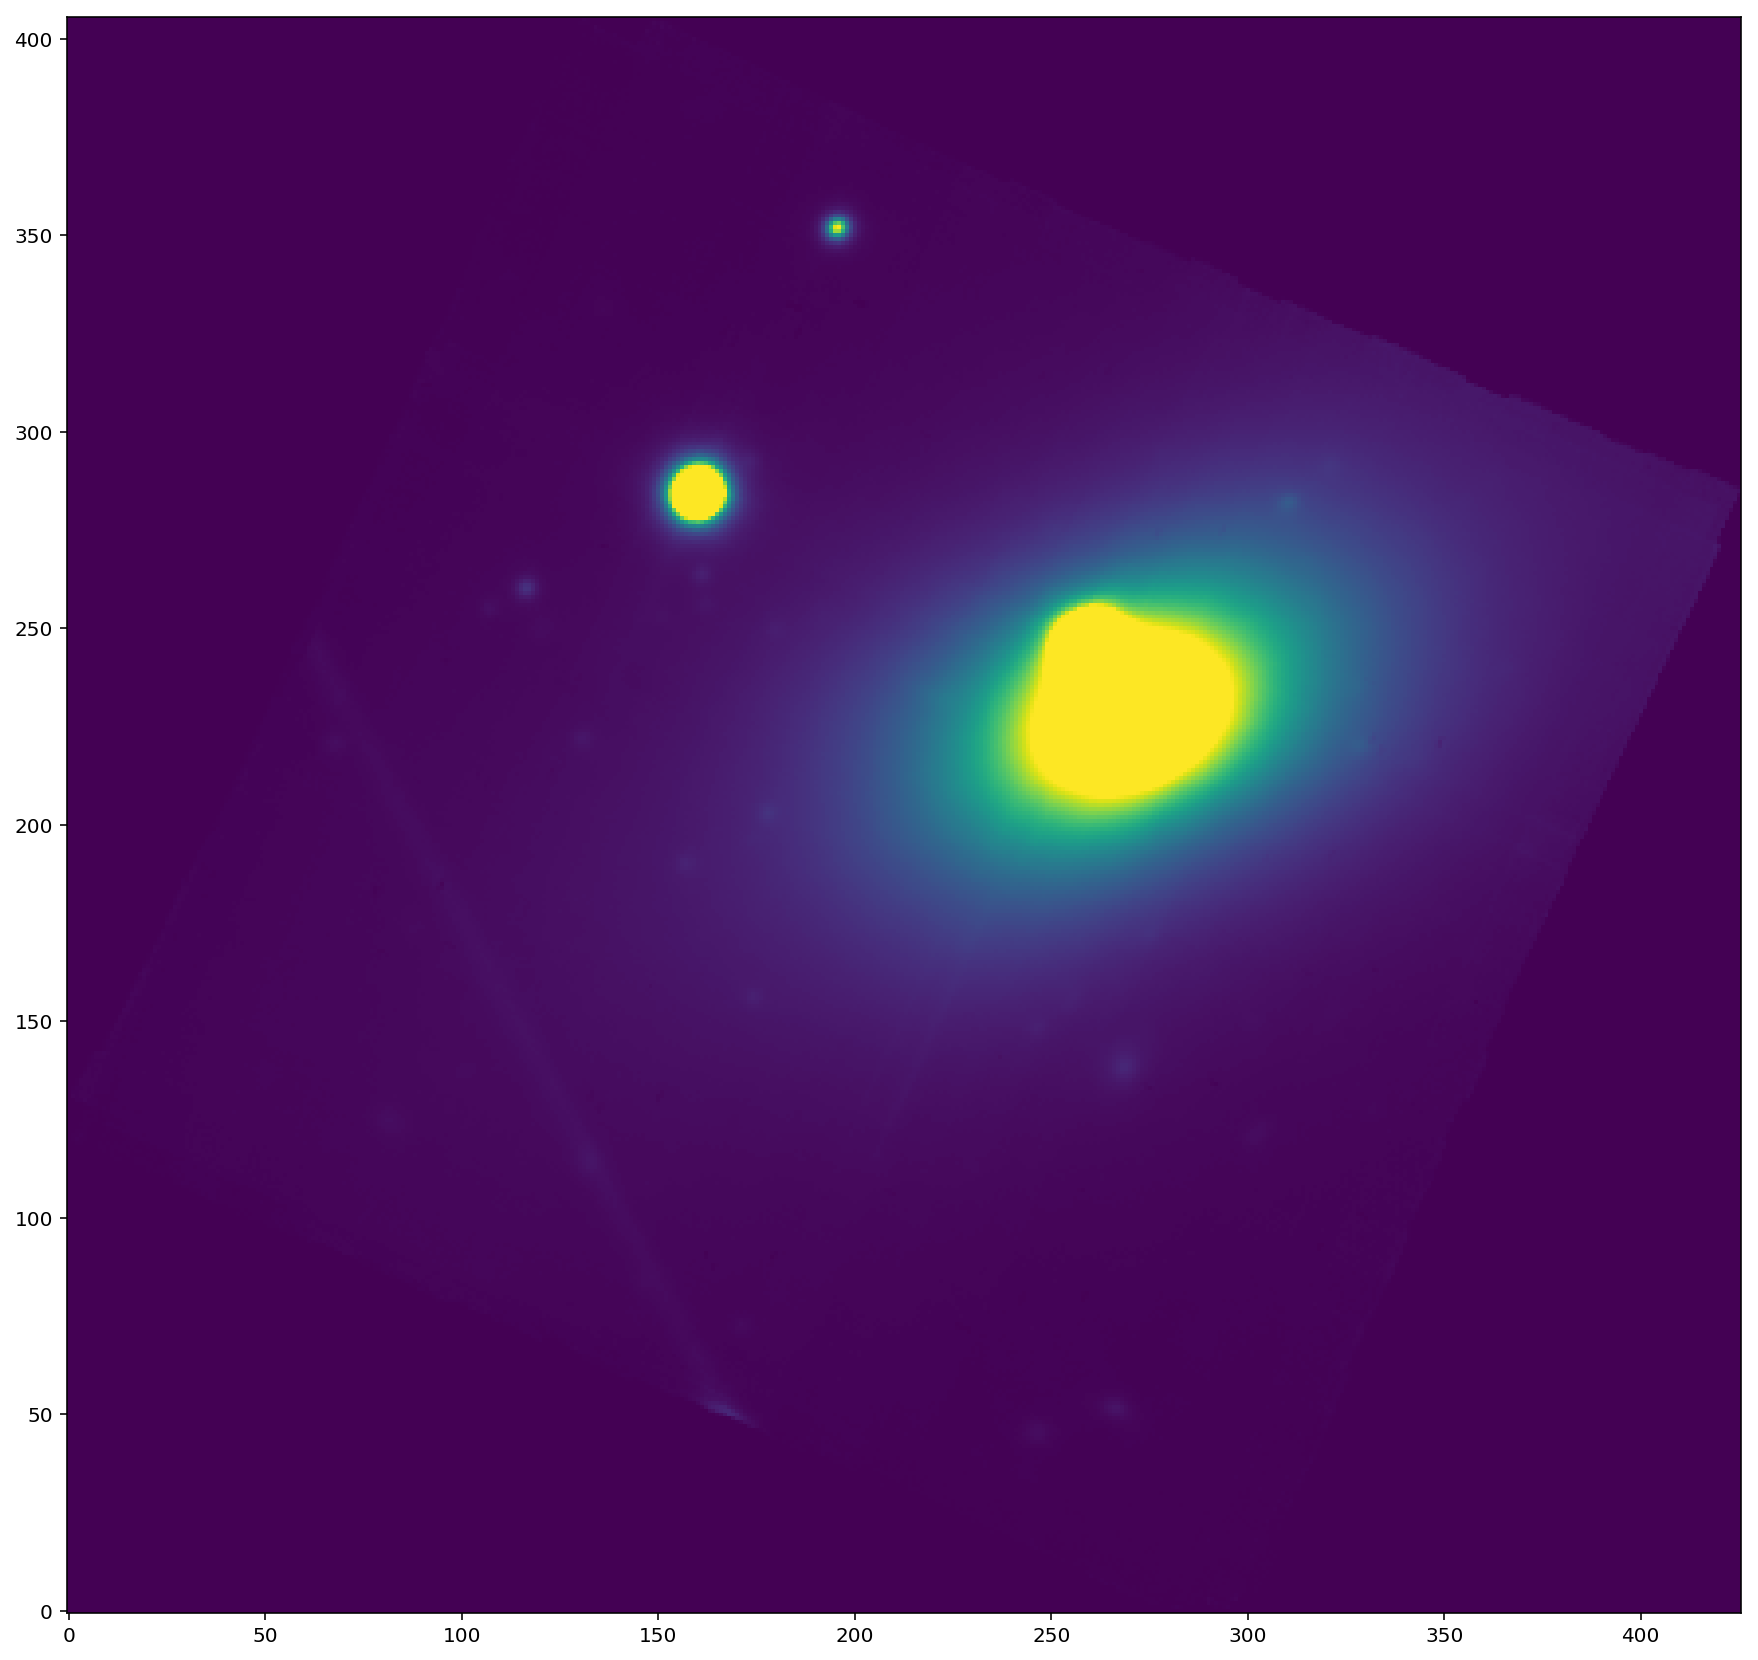

In [15]:
plt.figure(figsize=(15,15))
plt.imshow(np.sum(lnl_cube,2), origin="lower", vmin=0, vmax=500000)

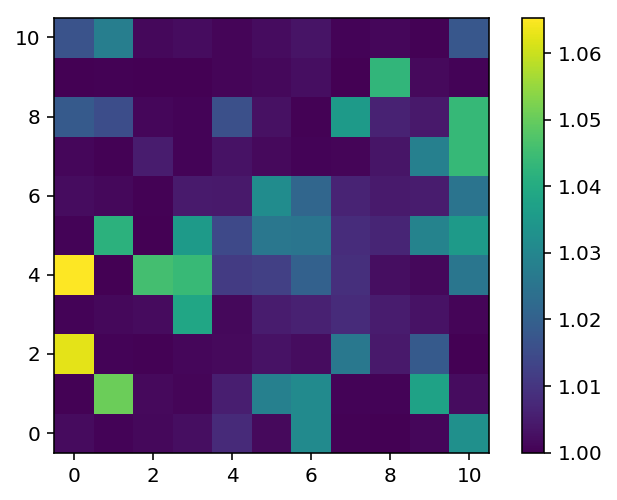

In [6]:
plt.imshow(1/obj_error_cube[12][:,0].reshape(n_pixels,n_pixels), origin="lower")
plt.colorbar()

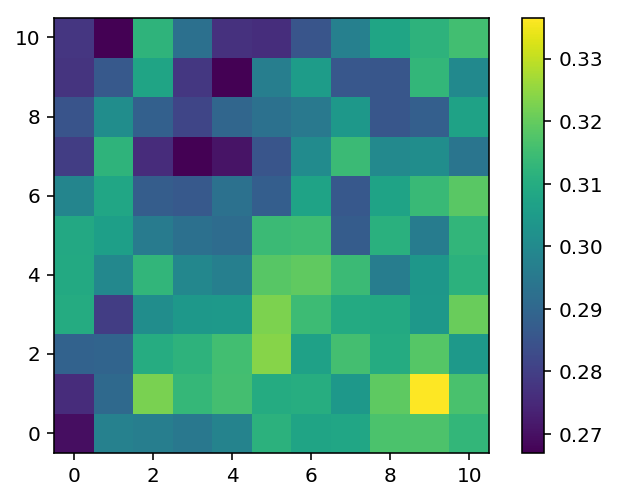

In [8]:
plt.imshow(1/error_cube[12][:,0].reshape(n_pixels,n_pixels), origin="lower")
plt.colorbar()

# 3D fitting routine

$$ f(x,y) = A \Big(1+ \frac{(x - x_0)^2 + (y - y_0)^2}{\gamma^2}\Big)^{-\beta} $$

In [10]:
# Parameter setup

PNe_params = Parameters()
PNe_params.add('Amp_2D', value=100., min=0.01)
#PNe_params.add("Amp_2", value=20, min=0.01)
PNe_params.add('x_0', value=(n_pixels/2.), min=0.01, max=n_pixels)
PNe_params.add('y_0', value=(n_pixels/2.), min=0.01, max=n_pixels)
PNe_params.add("M_FWHM", value=4.09, min=3.4, max=4.2, vary=False)
#PNe_params.add("G_FWHM", value=3., min=0.1,  vary=True) # Signal
#PNe_params.add("G_FWHM_2", value=8.,min=0.1, vary=True) # Noise - Set FWHM to higher value to control which Gauss model is signal and which is noise
PNe_params.add("beta", value=2.7, min=2.6, max=3.0, vary=False) #1.46
PNe_params.add("wave", value=5035., min=5000., max=5080.)
PNe_params.add("Gauss_bkg",  value=0.001)
PNe_params.add("Gauss_grad", value=0.001)

#use
#4.09
#2.7

FWHM_in_err = 0.2921
beta_in_err = 0.7567

# PNe - norm 0 and 3
#FWHM:      3.758294372477289 +/- 0.03762492436628986 (1.00%)
#Beta:      3.039459541330667 +/- 0.253194413692776 (8.33%)

# Star 0
#FWHM:      4.43394723 +/- 0.04765582 (1.07%)
#beta:      3.91199343 +/- 0.35874637 (9.17%)

# Star 1
#FWHM:      4.25553235 +/- 0.07033239 (1.65%)
#beta:      6.27049418 +/- 1.46347930 (23.34%)


# PNe 0
#FWHM:  4.045312487540704 +/- 0.08513141532957721 (2.10%)
#Beta:  2.8355912548658173 +/- 0.4302929262366324 (15.17%)

# PNe 3
#FWHM:  4.172879628529665 +/- 0.128084261247245 (3.07%)
#Beta:  2.5882319370453617 +/- 0.49827468987340845 (19.25%)

# PNe 0 and 3
#FWHM:  4.097199378103915 +/- 0.07372096340678978 (1.80%)
#Beta:  2.705787131855173 +/- 0.32699615666270926 (12.09%)


## Fitting routine

In [3]:
# useful value storage setup
total_Flux = np.zeros(len(x_PNe))
residuals_list = np.zeros(len(x_PNe))
A_OIII_list = np.zeros(len(x_PNe))
F_OIII_xy_list = np.zeros((len(x_PNe), len(PNe_spectra[0])))
M_amp_list = np.zeros(len(x_PNe))
mean_wave_list = np.zeros(len(x_PNe))
list_of_fit_residuals = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength)))

# error lists
moff_A_err = np.zeros(len(x_PNe))
x_0_err = np.zeros(len(x_PNe))
y_0_err = np.zeros(len(x_PNe))
mean_wave_err = np.zeros(len(x_PNe))
Gauss_bkg_err = np.zeros(len(x_PNe))
Gauss_grad_err = np.zeros(len(x_PNe))

FWHM_list = np.zeros(len(x_PNe))
list_of_x = np.zeros(len(x_PNe))
list_of_y = np.zeros(len(x_PNe))
Gauss_bkg = np.zeros(len(x_PNe))
Gauss_grad = np.zeros(len(x_PNe))

for PNe_num in np.arange(0, len(x_PNe)):
    useful_stuff = []
    #run minimizer fitting routine
    fit_results = minimize(MUSE_3D_residual, PNe_params, args=(wavelength, x_fit, y_fit, PNe_spectra[PNe_num], error_cube[PNe_num], PNe_num, "short", {}, useful_stuff), nan_policy="propagate")
    # Store values in numpy arrays
    PNe_df.loc[PNe_num, "Total Flux"] = np.sum(useful_stuff[1][1]) * 1e-20
    list_of_fit_residuals[PNe_num] = useful_stuff[0]
    A_OIII_list[PNe_num] = useful_stuff[1][0]
    F_OIII_xy_list[PNe_num] = useful_stuff[1][1]
    M_amp_list[PNe_num] = fit_results.params["Amp_2D"]
    list_of_x[PNe_num] = fit_results.params["x_0"]
    list_of_y[PNe_num] = fit_results.params["y_0"]
    mean_wave_list[PNe_num] = fit_results.params["wave"]
    Gauss_bkg[PNe_num] = fit_results.params["Gauss_bkg"]
    Gauss_grad[PNe_num] = fit_results.params["Gauss_grad"]
    #save errors
    moff_A_err[PNe_num] = fit_results.params["Amp_2D"].stderr
    x_0_err[PNe_num] = fit_results.params["x_0"].stderr
    y_0_err[PNe_num] = fit_results.params["y_0"].stderr
    mean_wave_err[PNe_num] = fit_results.params["wave"].stderr
    Gauss_bkg_err[PNe_num] = fit_results.params["Gauss_bkg"].stderr
    Gauss_grad_err[PNe_num] = fit_results.params["Gauss_grad"].stderr

# Signal to noise and Magnitude calculations
list_of_rN = np.array([np.std(PNe_res) for PNe_res in list_of_fit_residuals])
A_by_rN = A_OIII_list / list_of_rN
PNe_df["A/rN"] = A_by_rN

de_z_means = mean_wave_list / (1 + z)

PNe_df["V (km/s)"] = (c * (de_z_means - 5007) / 5007) / 1000

def log_10(x):
    return np.log10(x)

PNe_df["m 5007"] = -2.5 * PNe_df["Total Flux"].apply(log_10) - 13.74
dM =  5. * np.log10(D) + 25   # 31.63
PNe_df["M 5007"] = PNe_df["m 5007"] - dM

#Plotting
plt.figure(1, figsize=(12,10))
bins, bins_cens, other = plt.hist(PNe_df["m 5007"].loc[PNe_df["A/rN"]>2], bins=10, edgecolor="black", linewidth=0.8, label="m 5007 > 2 * A/rN", alpha=0.5)
#plt.hist(PNe_df["M 5007"].loc[PNe_df["A/rN"]<2], edgecolor="black",linewidth=0.8, color="red", alpha=0.5, label="M 5007 <2 * A/rN")
plt.xlim(26.0,30.0)
#plt.title("Absolute Magnitude Histogram", fontsize=24)
plt.xlabel("$m_{5007}$", fontsize=24)
plt.ylabel("N Sources", fontsize=24)
#plt.legend(fontsize=15)
#plt.savefig("Plots/FCC255/M5007 histogram.png")
bins_cens = bins_cens[:-1]
print(PNe_df["m 5007"].min())

NameError: name 'PNe_params' is not defined

# Multi wavelength fitting

In [9]:
z = 0.0053
emissions = {"Hb": [5, "wave_OIII_5007 - 145.518 * (1+{0})".format(z)],
             "Ha": [5,"wave_OIII_5007 + 1556.375 * (1+{0})".format(z)],
             "N_II_1": [5,"wave_OIII_5007 + 1541.621 * (1+{0})".format(z)],
             "N_II_2": [5,"wave_OIII_5007 + 1577.031 * (1+{0})".format(z)],
            }

param_test = Parameters()
param_test.add("wave_OIII_5007", value=5007.)
for em in emissions:
    param_test.add("Amp_2D_{}".format(em), value=emissions[em][0])
    param_test.add("wave_{}".format(em), expr=emissions[em][1])
    
param_test

In [ ]:
PNe_multi_params = Parameters()
# amplitude params
PNe_multi_params.add('Amp_2D_OIII_5007', value=100., min=0.01)
PNe_multi_params.add('Amp_2D_OIII_4959', expr="Amp_2D_OIII_5007/3")
PNe_multi_params.add('Amp_2D_Hb', value=1., min=0.01)
PNe_multi_params.add('Amp_2D_Ha', value=1., min=0.01)
PNe_multi_params.add('Amp_2D_NII_1', value=1., min=0.01)
PNe_multi_params.add('Amp_2D_NII_2', value=1., min=0.01)

PNe_multi_params.add('x_0', value=(n_pixels/2.), min=0.01, max=n_pixels)
PNe_multi_params.add('y_0', value=(n_pixels/2.), min=0.01, max=n_pixels)
PNe_multi_params.add("M_FWHM", value=4.09, min=3.4, max=4.2, vary=False)
PNe_multi_params.add("beta", value=2.7, min=2.6, max=3.0, vary=False)

# wavelengths params
PNe_multi_params.add("wave_OIII_5007", value=5035., min=5000., max=5080.)
PNe_multi_params.add("wave_OIII_4959", expr="wave_OIII_5007 - 47.9399")
PNe_multi_params.add("wave_Hb", expr="wave_OIII_5007 - 145.518 * (1+{0})".format(z))
PNe_multi_params.add("wave_Ha", expr="wave_OIII_5007 + 1556.375 * (1+{0})".format(z))
PNe_multi_params.add("wave_NII_1", expr="wave_OIII_5007 + 1541.621 * (1+{0})".format(z))
PNe_multi_params.add("wave_NII_2", expr="wave_OIII_5007 + 1577.031 * (1+{0})".format(z))

PNe_multi_params.add("Gauss_bkg",  value=0.00001)
PNe_multi_params.add("Gauss_grad", value=0.00001)


total_Flux = np.zeros((len(x_PNe),6))
A_2D_list = np.zeros(len(x_PNe))
F_xy_list = np.zeros((len(x_PNe), 6, len(PNe_spectra[0])))
emission_amp_list = np.zeros((len(x_PNe),6))
model_spectra_list = np.zeros((len(x_PNe), n_pixels*n_pixels, len(full_wavelength)))
mean_wave_list = np.zeros((len(x_PNe),6))
residuals_list = np.zeros(len(x_PNe))
list_of_fit_residuals = np.zeros((len(x_PNe), n_pixels*n_pixels, len(full_wavelength)))

# error lists
moff_A_err = np.zeros((len(x_PNe),6))
x_0_err = np.zeros(len(x_PNe))
y_0_err = np.zeros(len(x_PNe))
mean_wave_err = np.zeros((len(x_PNe),6))
Gauss_bkg_err = np.zeros(len(x_PNe))
Gauss_grad_err = np.zeros(len(x_PNe))

FWHM_list = np.zeros(len(x_PNe))
list_of_x = np.zeros(len(x_PNe))
list_of_y = np.zeros(len(x_PNe))
Gauss_bkg = np.zeros(len(x_PNe))
Gauss_grad = np.zeros(len(x_PNe))

useful_stuff = []
emissions = {"Hb": [5, "- 145.518"],
             "Ha": [5,"+ 1556.375"],
             "NII_1": [5,"+ 1541.621"],
             "NII_2": [5,"+ 1577.031"]}

for PNe_num in np.arange(0, len(x_PNe)):
    multi_fit_results = minimize(MUSE_3D_residual, PNe_multi_params, args=(full_wavelength, x_fit, y_fit, PNe_spectra[PNe_num], error_cube[PNe_num], PNe_num, emissions, useful_stuff), nan_policy="propagate")
    total_Flux[PNe_num] = np.sum(useful_stuff[1][1],1) * 1e-20
    list_of_fit_residuals[PNe_num] = useful_stuff[0]
    A_2D_list[PNe_num] = useful_stuff[1][0]
    F_xy_list[PNe_num] = useful_stuff[1][1]
    model_spectra_list[PNe_num] = useful_stuff[1][3]
    emission_amp_list[PNe_num] = [multi_fit_results.params["Amp_2D_OIII_5007"], multi_fit_results.params["Amp_2D_OIII_4959"], multi_fit_results.params["Amp_2D_Hb"],
                                  multi_fit_results.params["Amp_2D_Ha"], multi_fit_results.params["Amp_2D_NII_1"], multi_fit_results.params["Amp_2D_NII_2"]]    
    mean_wave_list[PNe_num] = [multi_fit_results.params["wave_OIII_5007"], multi_fit_results.params["wave_OIII_4959"], multi_fit_results.params["wave_Hb"],
                               multi_fit_results.params["wave_Ha"], multi_fit_results.params["wave_NII_1"], multi_fit_results.params["wave_NII_2"]]    
    list_of_x[PNe_num] = multi_fit_results.params["x_0"]
    list_of_y[PNe_num] = multi_fit_results.params["y_0"]
    Gauss_bkg[PNe_num] = multi_fit_results.params["Gauss_bkg"]
    Gauss_grad[PNe_num] = multi_fit_results.params["Gauss_grad"]
    display(PNe_num)
    #save errors
    #moff_A_err[PNe_num] = multi_fit_results.params["Amp_2D"].stderr
    #x_0_err[PNe_num] = multi_fit_results.params["x_0"].stderr
    #y_0_err[PNe_num] = multi_fit_results.params["y_0"].stderr
    #mean_wave_err[PNe_num] = multi_fit_results.params["mean"].stderr
    #Gauss_bkg_err[PNe_num] = multi_fit_results.params["Gauss_bkg"].stderr
    #Gauss_grad_err[PNe_num] = multi_fit_results.params["Gauss_grad"].stderr

list_of_rN = np.array([np.std(PNe_res) for PNe_res in list_of_fit_residuals])
PNe_df["A/rN"] = A_2D_list / list_of_rN

de_z_means = mean_wave_list[:][0] / (1 + z)

PNe_df["V (km/s)"] = (c * (de_z_means - 5007.) / 5007.) / 1000.

PNe_df["[OIII] Flux"] = total_flux[:][0]

PNe_df["[OIII]/Hb"] = PNe_df["[OIII] Flux"] / total_flux[:][2]

def log_10(x):
    return np.log10(x)

PNe_df["m 5007"] = -2.5 * PNe_df["Total Flux"].apply(log_10) - 13.74
dM =  5. * np.log10(D) + 25.   # 31.63
PNe_df["M 5007"] = PNe_df["m 5007"] - dM

Dist_est = 10.**(((PNe_df["m 5007"].min() + 4.5) -25.) / 5.)
print("Distance Estimate from PNLF: ", Dist_est, "Mpc")

PNe_table = Table([np.arange(0,len(x_PNe)), np.round(x_PNe), np.round(y_PNe), PNe_df["[OIII] Flux"], PNe_df["[OIII]/Hb"], PNe_df["m 5007"], PNe_df["M 5007"]], 
          names=("PNe number", "x", "y", "[OIII] Flux", "[OIII]/Hb", "m 5007", "M 5007"))
ascii.write(PNe_table, "FCC277_PNe_table.txt", format="tab")
print("Table Created and saved.")

In [14]:
report_fit(multi_fit_results)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 56
    # data points      = 312301
    # variables        = 10
    chi-square         = 318503.547
    reduced chi-square = 1.01989346
    Akaike info crit   = 6161.75682
    Bayesian info crit = 6268.27405
[[Variables]]
    Amp_2D_OIII_5007:  132.251576 +/- 5.37012991 (4.06%) (init = 100)
    Amp_2D_OIII_4959:  44.0838586 +/- 1.79004330 (4.06%) == 'Amp_2D_OIII_5007/3'
    Amp_2D_Hb:         64.7449129 +/- 5.57003583 (8.60%) (init = 1)
    Amp_2D_Ha:         87.8167102 +/- 6.47011172 (7.37%) (init = 1)
    Amp_2D_NII_1:      67.5733729 +/- 6.46125923 (9.56%) (init = 1)
    Amp_2D_NII_2:      8.22265528 +/- 6.47676992 (78.77%) (init = 1)
    x_0:               5.26019392 +/- 0.08493673 (1.61%) (init = 5.5)
    y_0:               5.70025085 +/- 0.08581522 (1.51%) (init = 5.5)
    M_FWHM:            4.09 (fixed)
    beta:              2.7 (fixed)
    wave_OIII_5007:    5034.77142 +/- 0.05225206 (0.00%) (init = 50

In [5]:
A_2D_list

array([44.77684213, 15.92728857, 39.12823172,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

Text(0,0.5,'Flux')

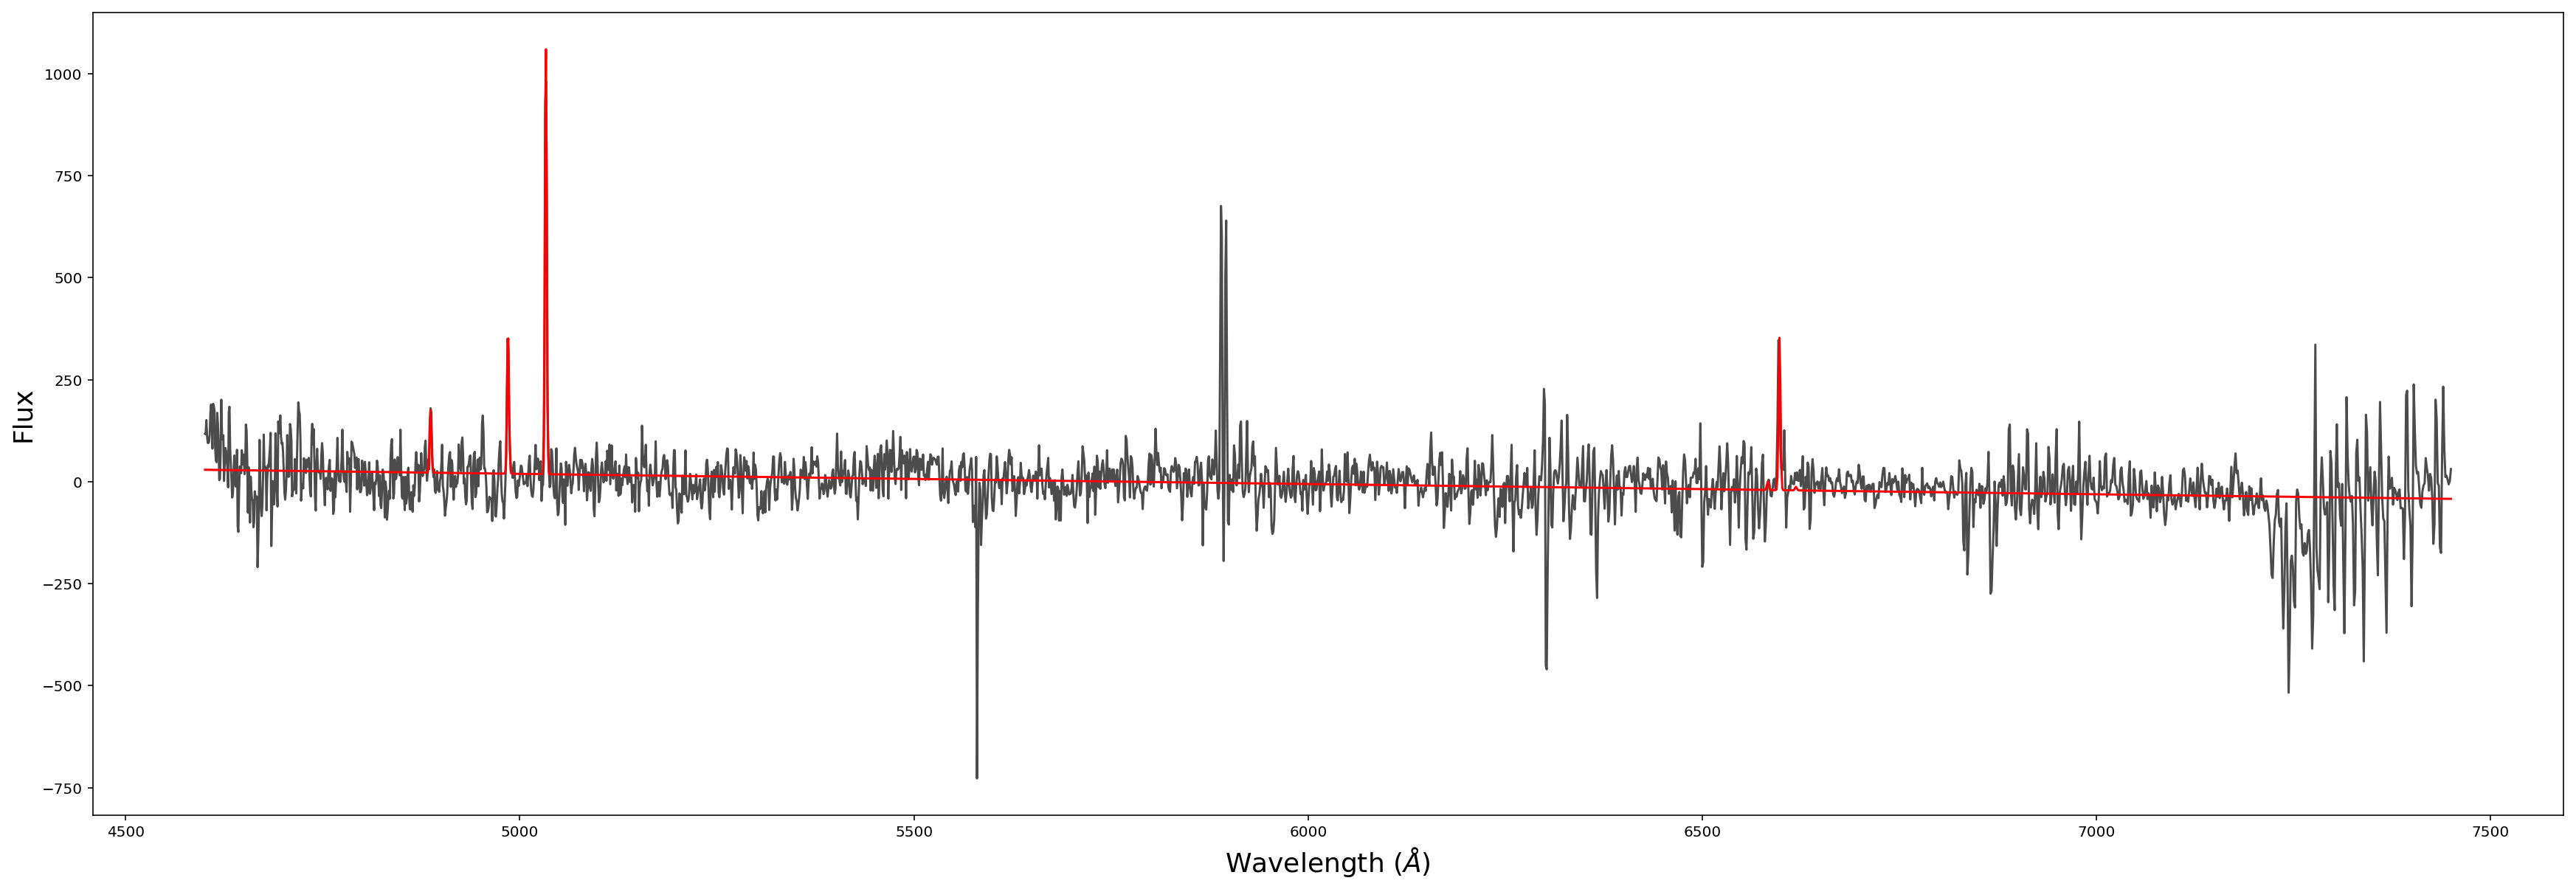

In [15]:
p = 0
plt.figure(figsize=(30,10))
plt.plot(full_wavelength, np.sum(PNe_spectra[p],0), alpha=0.7, c="k")

plt.plot(full_wavelength, np.sum(model_spectra_list[p],0), c="r")
plt.xlabel("Wavelength ($\AA$)", fontsize=18)
plt.ylabel("Flux", fontsize=18)

#plt.savefig("Plots/FCC277/full_fit_sum_spec.png")

In [16]:
PNe_df

,PNe number,Ra (J2000),Dec (J2000),[OIII] Flux,[OIII]/Hb,Flux error,V (km/s),m 5007,M 5007,M 5007 error,A/rN,rad D
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


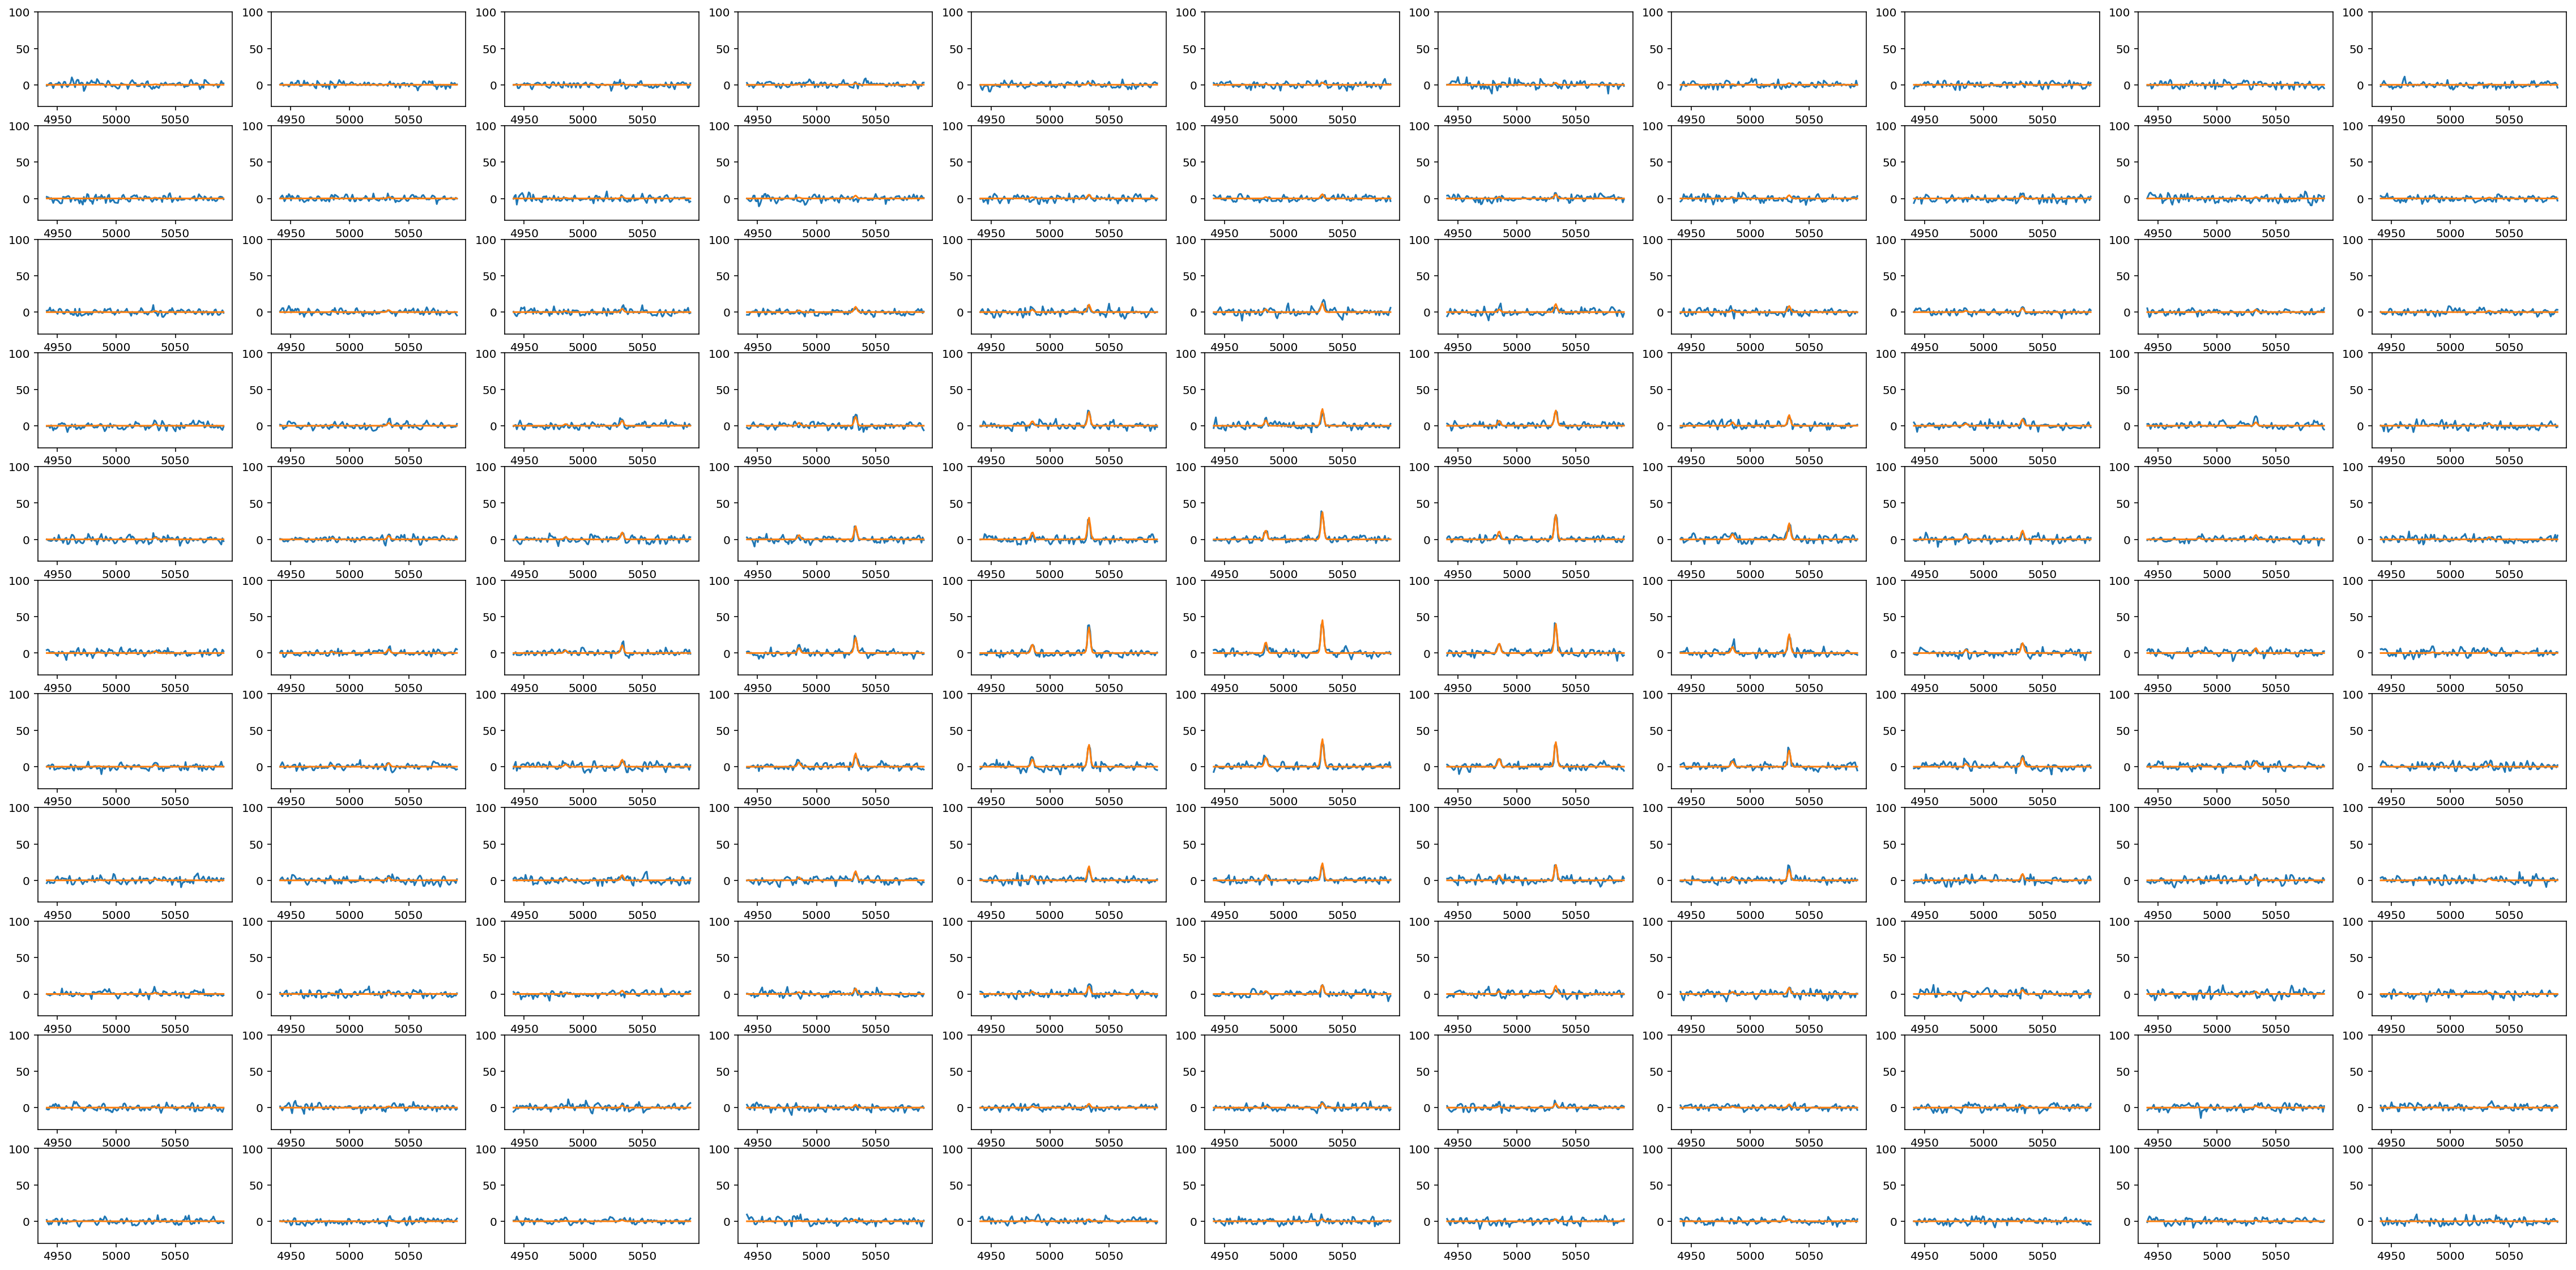

In [47]:
p = 0
PNe_n = PNe_spectra[p]
flux_1D = F_OIII_xy_list[p]
A_n = ((flux_1D) / (np.sqrt(2*np.pi) * 1.19))

def gaussian(x, amplitude, wave, stddev, bkg, grad):
    return (bkg + grad*x + np.abs(amplitude) * np.exp(- 0.5 * (x - wave)** 2 / (stddev**2.)) +
                 (np.abs(amplitude)/3.) * np.exp(- 0.5 * (x - (wave - 47.9399))** 2 / (stddev**2.)))

list_of_gauss = [gaussian(wavelength, A, mean_wave_list[p], 1.19, Gauss_bkg[p], Gauss_grad[p]) for A in A_n]

plt.figure(figsize=(40,20))
for i, spec in enumerate(PNe_n):
    plt.subplot(n_pixels,n_pixels,i+1)
    plt.plot(wavelength, spec)
    plt.plot(wavelength, list_of_gauss[i])
    plt.ylim(-30, 100)
    

#plt.savefig("Plots/FCC277/PNe_0_spectra_grid.png")

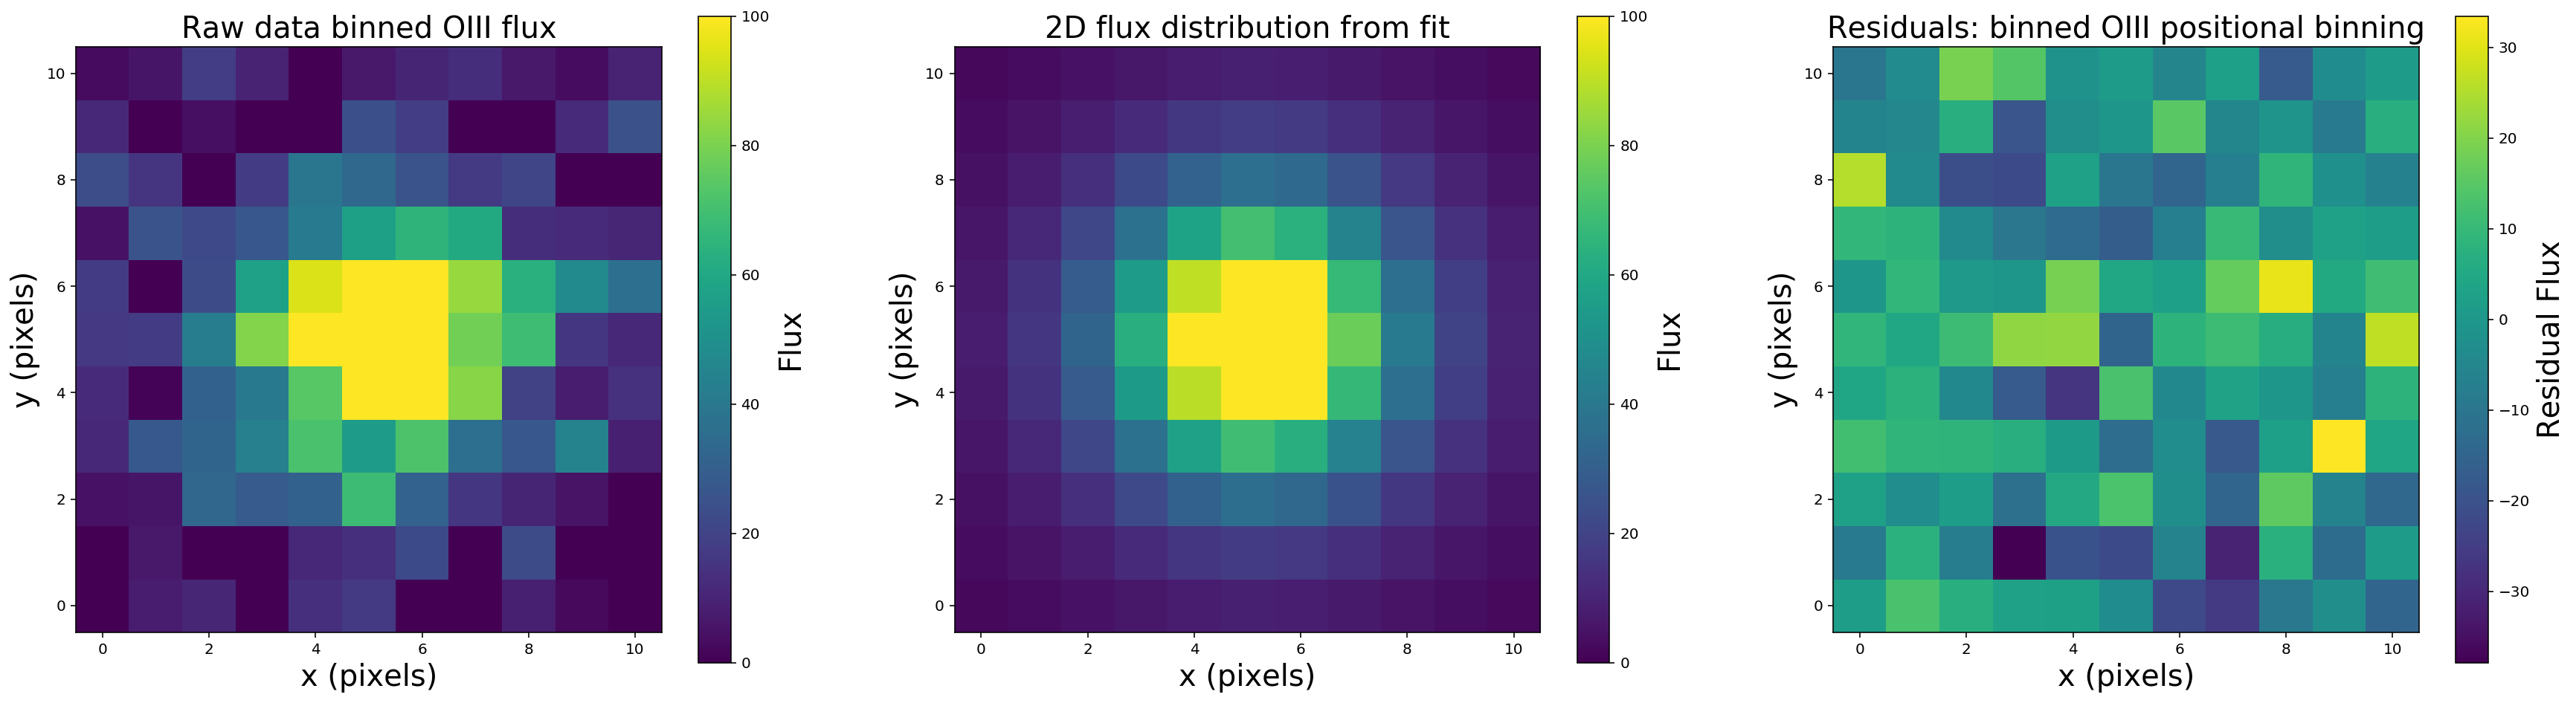

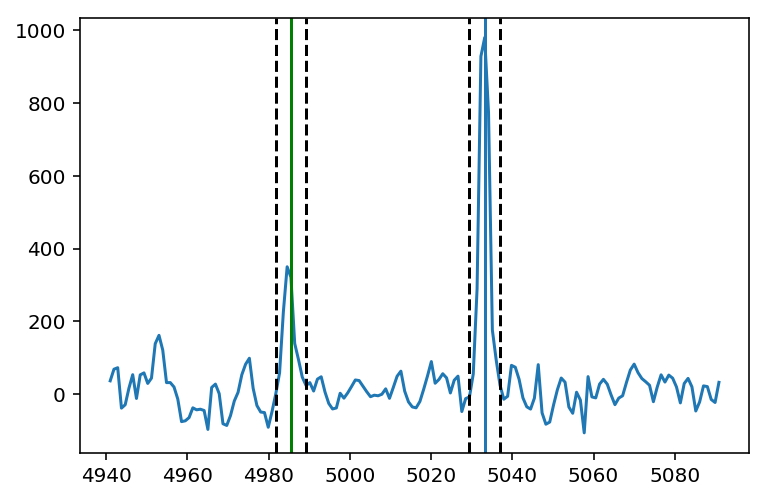

In [48]:
#(p, p+1)
for n in np.arange(p,p+1):#0, len(x_PNe)):
    PNe_n = PNe_spectra[n]
    sum_n = np.sum(PNe_n,0)
    mean_n = mean_wave_list[n]
    peak_0 = min(range(len(wavelength)), key=lambda i: abs(wavelength[i]-mean_wave_list[n]))
    peak_1 = min(range(len(wavelength)), key=lambda i: abs(wavelength[i]-(mean_wave_list[n]-47.93)))
    #if (peak_1 is not peak_0 - 38) or (peak_1 is not peak_0 - 37):
    #    peak_1 = peak_0 - 38
    
    sum_peak_0 = np.sum(PNe_n[:,peak_0-4:peak_0+4],1)
    sum_peak_1 = 0# np.sum(PNe_n[:,peak_1-4:peak_1+4],1)
    combined_peaks = sum_peak_0 + sum_peak_1
    combined_peaks_2D = combined_peaks.reshape(n_pixels, n_pixels)
    
    result_res = list_of_fit_residuals[n]
    result_res_list = result_res.reshape(n_pixels* n_pixels, len(wavelength))
    sum_peak_res_0 = np.sum(result_res_list[:,peak_0-2:peak_0+2],1)
    sum_peak_res_1 = np.sum(result_res_list[:,peak_1-2:peak_1+2],1)
    combined_peaks_res = sum_peak_res_0 + sum_peak_res_1
    combined_peaks_res_2D = combined_peaks_res.reshape(n_pixels, n_pixels)
    
    plt.figure(figsize=(30,8))
    plt.subplot(1,3,1)
    plt.imshow(combined_peaks_2D, origin="lower", vmin=0, vmax=100)
    plt.xlabel("x (pixels)", fontsize=20)
    plt.ylabel("y (pixels)", fontsize=20)
    plt.title("Raw data binned OIII flux", fontsize=20)
    cb = plt.colorbar(label="Flux")
    cb.set_label("Flux", fontsize=20)
    
    plt.subplot(1,3,2)
    plt.imshow(F_OIII_xy_list[n].reshape(n_pixels,n_pixels), origin="lower", vmin=0, vmax=100)
    plt.xlabel("x (pixels)", fontsize=20)
    plt.ylabel("y (pixels)", fontsize=20)
    plt.title("2D flux distribution from fit", fontsize=20)
    cb = plt.colorbar()
    cb.set_label("Flux", fontsize=20)
    
    plt.subplot(1,3,3)
    plt.imshow(combined_peaks_res_2D, origin="lower", vmin=np.min(combined_peaks_res_2D), vmax=np.max(combined_peaks_res_2D))
    plt.xlabel("x (pixels)", fontsize=20)
    plt.ylabel("y (pixels)", fontsize=20)
    plt.title("Residuals: binned OIII positional binning", fontsize=20)
    cb = plt.colorbar()
    cb.set_label("Residual Flux", fontsize=20)
    
    plt.savefig("Plots/FCC277/data_model_residual_good.png")
    
    plt.figure(7)
    plt.plot(wavelength, sum_n)
    plt.axvline(wavelength[peak_0])
    plt.axvline(wavelength[peak_0+4], ls="dashed", c="k")
    plt.axvline(wavelength[peak_0-4], ls="dashed", c="k")
    
    plt.axvline(wavelength[peak_1], c="green")
    plt.axvline(wavelength[peak_1+4], ls="dashed", c="k")
    plt.axvline(wavelength[peak_1-4], ls="dashed", c="k")


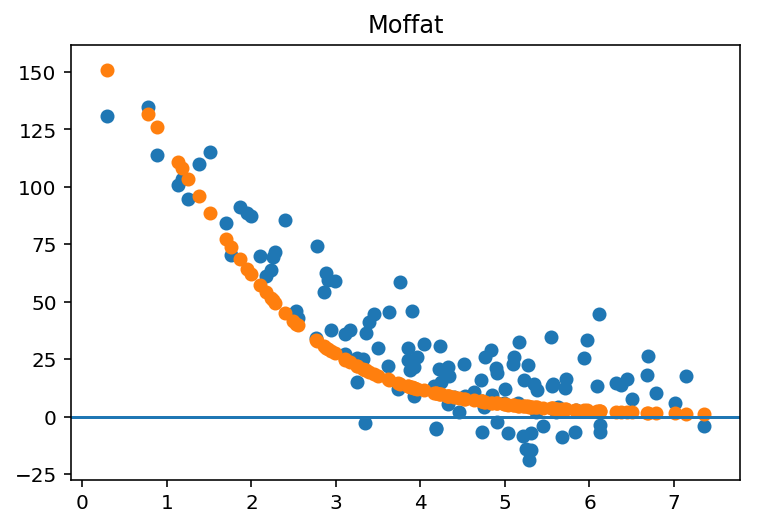

In [42]:
PNe_radials= np.sqrt((x_fit - list_of_x[p])**2 + (y_fit - list_of_y[p])**2)
plt.title("Moffat")
plt.scatter(PNe_radials, combined_peaks_2D)
plt.scatter(PNe_radials, F_OIII_xy_list[p])
#plt.axvline(r)
plt.axhline(0)

In [ ]:
PNe_radials= np.sqrt((x_fit - list_of_x[p])**2 + (y_fit - list_of_y[p])**2)
plt.title("Gaussian")
plt.scatter(PNe_radials, combined_peaks_2D)
plt.scatter(PNe_radials, F_OIII_xy_list[p])
plt.axvline(r)
plt.axhline(0)

In [ ]:
PNe_radials= np.sqrt((x_fit - list_of_x[p])**2 + (y_fit - list_of_y[p])**2)
plt.title("2 Gaussian")
plt.scatter(PNe_radials, combined_peaks_2D)
plt.scatter(PNe_radials, useful_stuff[1][2])
plt.scatter(PNe_radials, useful_stuff[1][3])
plt.scatter(PNe_radials, useful_stuff[1][3]+useful_stuff[1][2])
plt.axvline((11/2.3548))
plt.axhline(0)

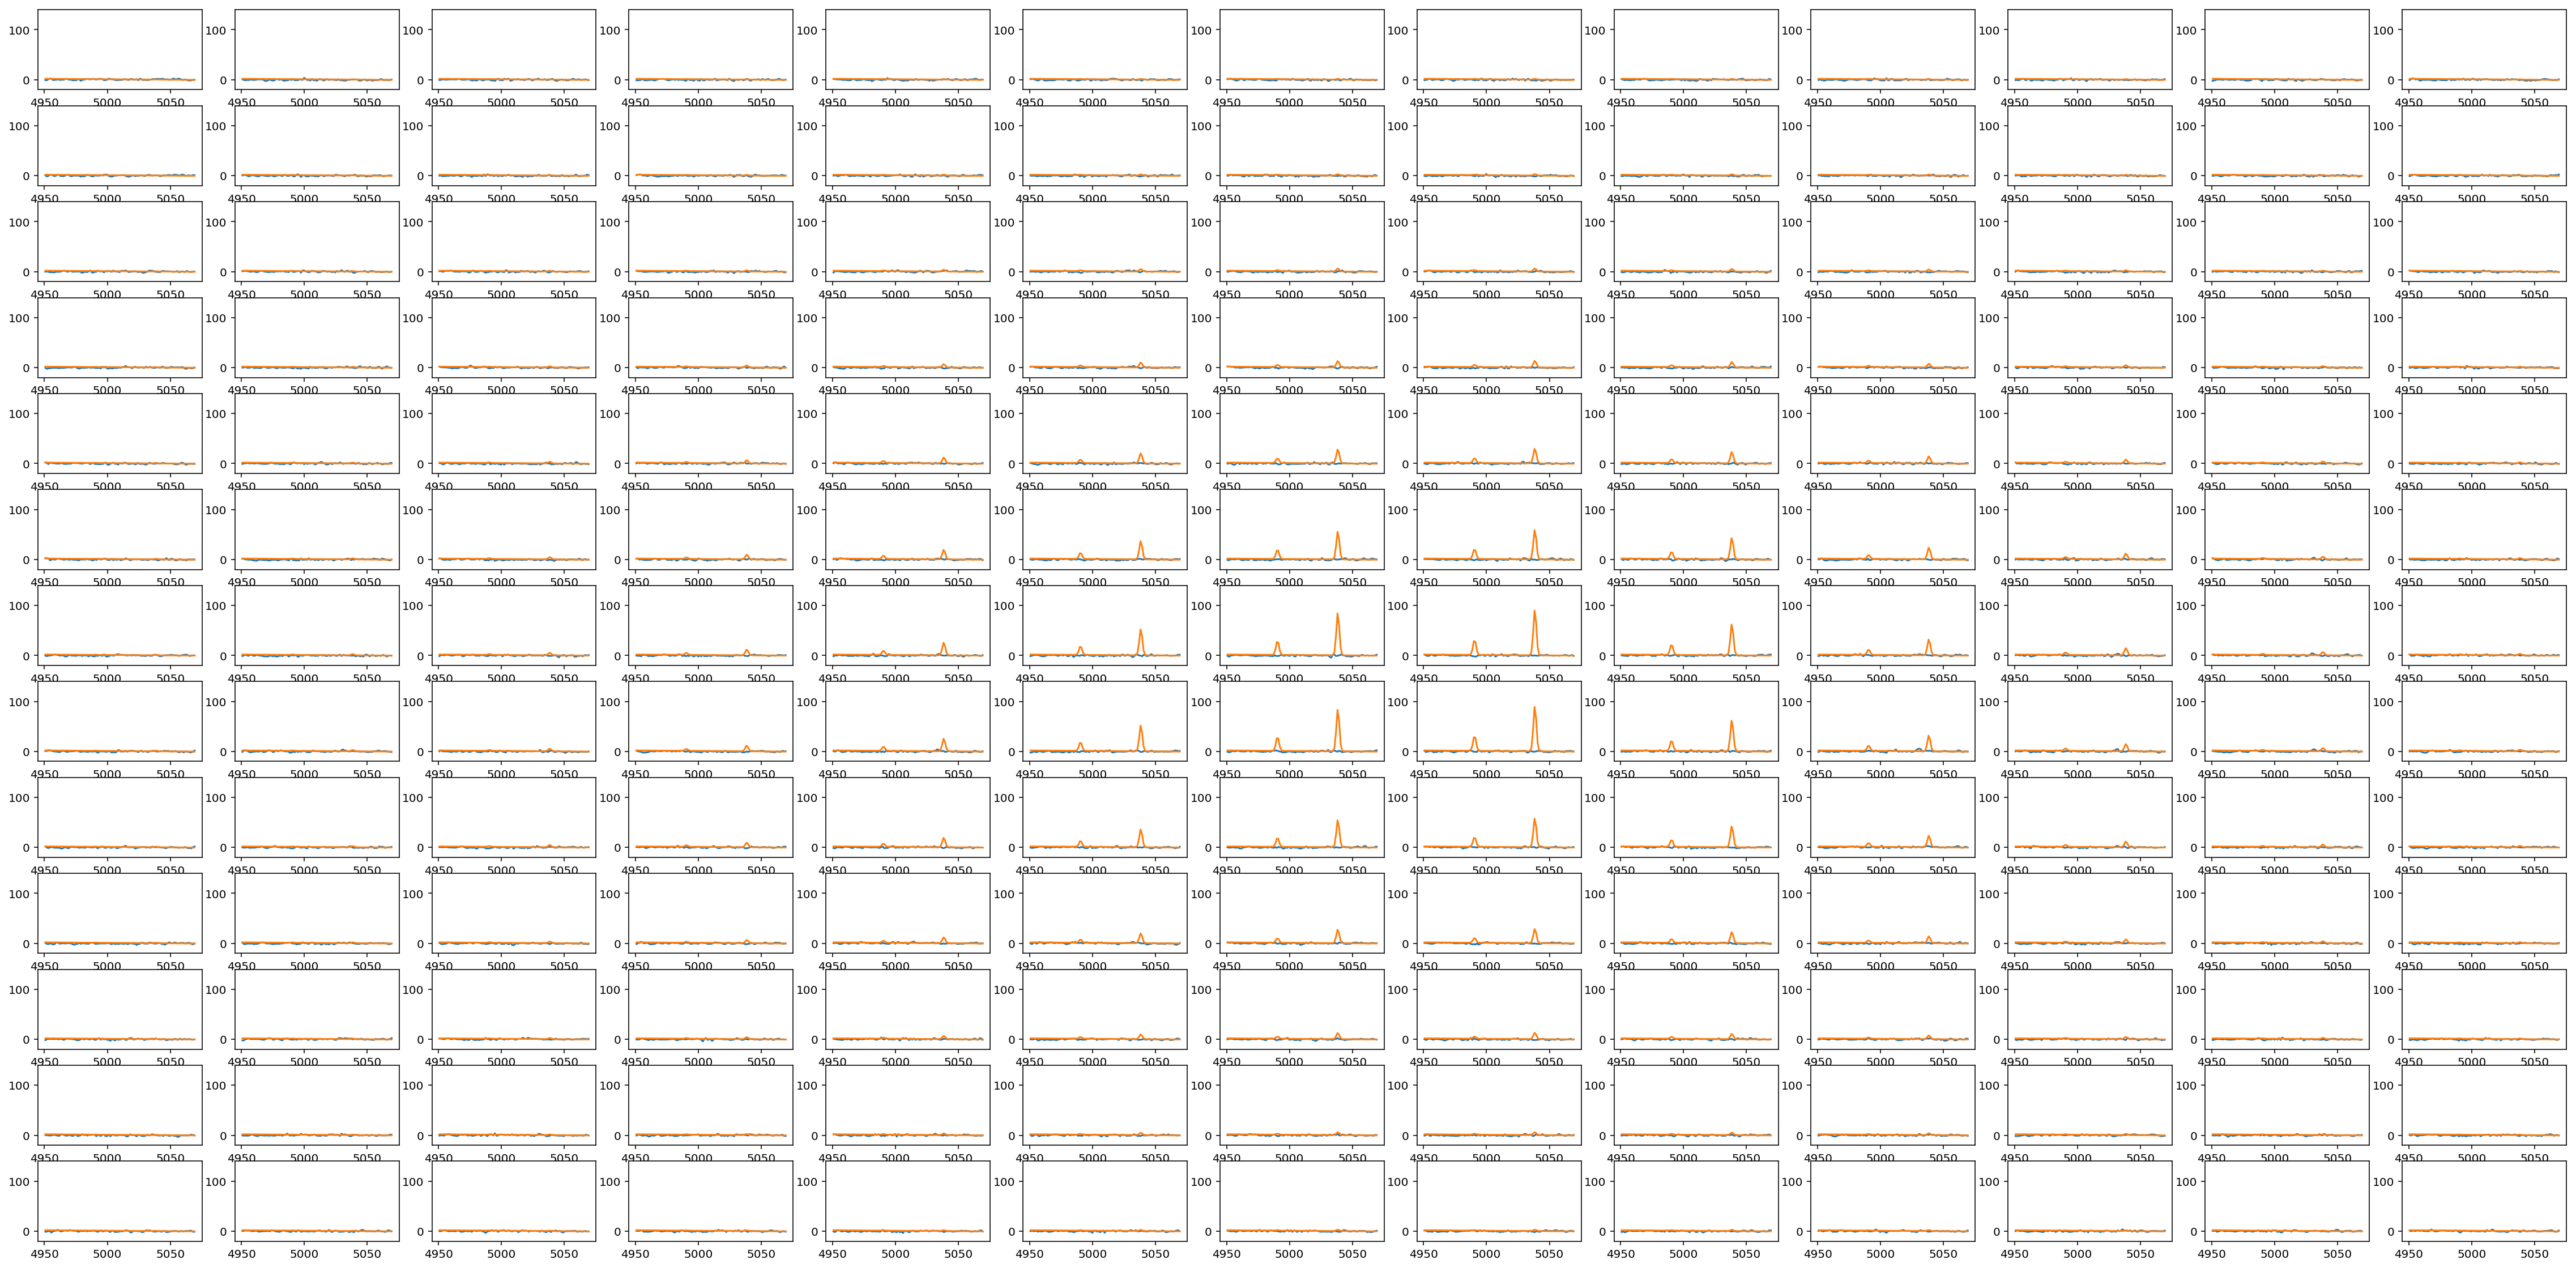

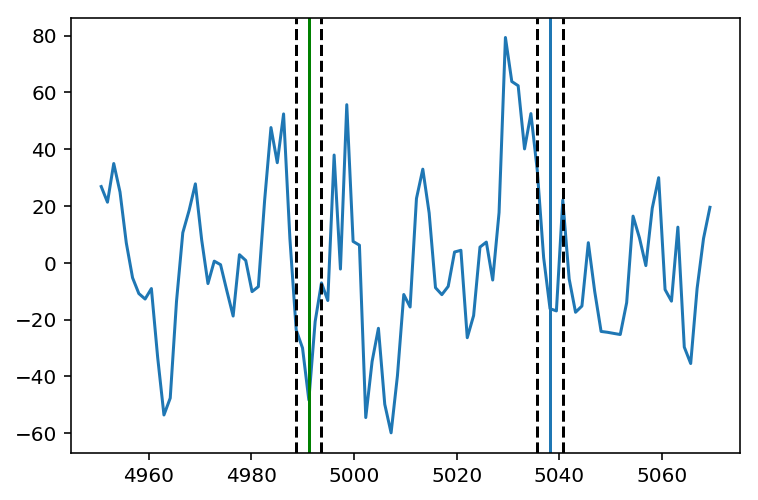

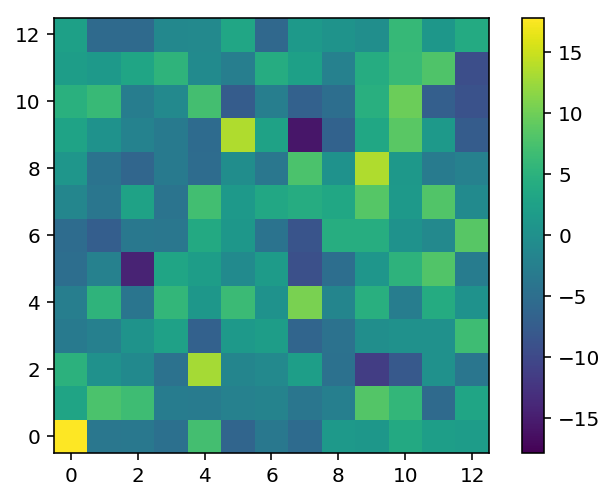

In [50]:
# Residual
result_res = fit_results.residual
result_res_list = result_res.reshape(n_pixels* n_pixels, len(wavelength))
plt.figure(0,figsize=(40,20))
for i, spec in enumerate(result_res_list):
    plt.subplot(n_pixels,n_pixels,i+1)
    plt.plot(wavelength, spec)
    plt.plot(wavelength, list_of_gauss[i])
    plt.ylim(-20,140)

sum_n_res = np.sum(result_res_list,0)
plt.figure(1)
plt.plot(wavelength, sum_n_res)
plt.axvline(wavelength[peak_0])
plt.axvline(wavelength[peak_0+2], ls="dashed", c="k")
plt.axvline(wavelength[peak_0-2], ls="dashed", c="k")

plt.axvline(wavelength[peak_1], c="green")
plt.axvline(wavelength[peak_1+2], ls="dashed", c="k")
plt.axvline(wavelength[peak_1-2], ls="dashed", c="k")

mean_n = mean_wave_list[n]
sum_peak_0 = np.sum(result_res_list[:,peak_0-4:peak_0+4],1)
sum_peak_1 = np.sum(result_res_list[:,peak_1-4:peak_1+4],1)
combined_peaks = sum_peak_0 + sum_peak_1
plt.figure(2)
plt.imshow(combined_peaks.reshape(n_pixels, n_pixels), origin="lower", vmin=-np.max(combined_peaks), vmax=np.max(combined_peaks))
plt.colorbar()

# Completeness

In [36]:
Noise_map = np.abs(np.std(raw_data_cube, axis=2))

# mask out regions where sep masks
#Y, X = np.mgrid[:y_data, :x_data]
#xe = 236
#ye = 197
#length= 140
#wide = 60
#alpha = 0.2
#elip_mask_gal = (((X-xe) * np.cos(alpha) + (Y-ye) * np.sin(alpha)) / (wide/2)) ** 2 + (((X-xe) * np.sin(alpha) - (Y-ye) * np.cos(alpha)) / (length/2)) ** 2 <= 1

#Noise_map[elip_mask_gal == True] = 0.0

#plt.imshow(Noise_map, origin="lower", cmap="CMRmap", vmin=0, vmax=20)

# Setup range of Absolute Magnitudes to be converted to 1D max A values
#Abs_M = bins_cens # np.arange(-4.5,-1.5, 0.5)#bins_cens
#dM = 5. * np.log10(18.7)+25
app_m = bins_cens

total_flux = 10**((app_m + 13.74) / -2.5)
flux = total_flux / 1e-20

def moffat(amplitude, x_0, y_0, FWHM, beta):
    gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((x_fit - x_0)**2 + (y_fit - y_0)**2) / gamma**2
    return amplitude * (1 + rr_gg)**(-beta)

def gaussian(x, amplitude, wave, stddev, bkg, grad):
    return (bkg + grad*x + np.abs(amplitude) * np.exp(- 0.5 * (x - wave)** 2 / (stddev**2.)) +
                 (np.abs(amplitude)/3.) * np.exp(- 0.5 * (x - (wave - 47.9399))** 2 / (stddev**2.)))

init_FWHM = PNe_params["M_FWHM"].value
init_beta = PNe_params["beta"].value
sum_init = np.sum(moffat(1, n_pixels/2, n_pixels/2, init_FWHM, init_beta))
input_moff_A = flux / sum_init

# Make moffat models = F_5007 (x,y)
Moffat_models = np.array([moffat(moff_A, n_pixels/2., n_pixels/2., init_FWHM, init_beta) for moff_A in input_moff_A])

# A_5007 (x,y)
Amp_x_y = ((Moffat_models) / (np.sqrt(2*np.pi) * 1.19))

max_1D_A = np.array([np.max(A) for A in Amp_x_y])

N_data = len(np.nonzero(Noise_map)[0])

Noise_mask = Noise_map
Noise_mask_plot = []
ratio_counter = np.zeros(len(app_m))
for i,a in enumerate(max_1D_A):
    Noise_mask[((a / Noise_map) <2.0)] = np.nan
    nan_counter = np.isnan(Noise_mask).sum()

    ratio_counter[i] = (N_data-nan_counter) / N_data
    Noise_mask_plot.append(Noise_mask)
#    plt.figure(figsize=(14,14))
#    plt.title("Absolute Magniude %s" %Abs_M[i])
#    plt.imshow(Noise_mask, origin="lower", vmin=0, vmax=20)
#    cb=plt.colorbar()
#    plt.savefig("Plots/FCC255/completeness/Abs M %s.png" %Abs_M[i])
#
#Noise_mask = Noise_map
#Noise_mask_plot = []
#
#fig, axs = plt.subplots(2,3, figsize=(20, 10))
#axs = axs.ravel()
#for i,a in enumerate(max_1D_A):
#    Noise_mask[((a / Noise_map) <2.0)] = np.nan
#    axs[i].set_title("$M_{5007} = $ %s" %Abs_M[i])
#    ax = axs[i].imshow(Noise_mask, origin="lower", vmin=0, vmax=30)
#
#plt.savefig("Plots/FCC255/completeness/stack.png")



C:\Users\Thomas Spriggs\Miniconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Thomas Spriggs\Miniconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less


## PNLF Fitting Routine

In [38]:
PNLF_df = pd.DataFrame(columns=("m 5007", "PNLF", "binned_values"))
PNLF_df["m 5007"] = PNe_df["m 5007"].loc[PNe_df["A/rN"]>2.0]

diff = abs(bins_cens[0]-bins_cens[1]) / 2
bins_cens_left = bins_cens - diff
bins_cens_right = bins_cens + diff

PNLF_df["binned_values"] = np.digitize(PNLF_df["m 5007"], bins=bins_cens)

def PNLF_func(params, data):
    c1 = params["c1"]
    c2 = params["c2"]
    
    # PNLF equation
    PNLF = c1*np.exp(c2*PNLF_df["m 5007"]) * (1-np.exp(3*((PNLF_df["m 5007"].min() - PNLF_df["m 5007"]))))
    PNLF_df["PNLF"] = PNLF
    # Binning of PNLF values
    PNLF_sum_list = np.zeros(len(bins_cens))
    for i in np.arange(1,len(bins_cens)+1):
        PNLF_sum_list[i-1] = np.mean(PNLF_df["PNLF"].loc[PNLF_df["binned_values"]==i])
    # Scale the binned values

    return data - PNLF_sum_list
                
params_PNLF = Parameters()
params_PNLF.add("c1", value=50)
params_PNLF.add("c2", value=0.307, vayr=False)

results = minimize(PNLF_func, params_PNLF, args=(bins,), nan_policy="propagate")
#plt.hist(PNe_df["M 5007"].loc[PNe_df["A/rN"]>2], edgecolor="black", linewidth=0.8, label="M 5007 >2 * A/rN", alpha=0.5)
report_fit(results)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 372
    # data points      = 9
    # variables        = 2
    chi-square         = 39.7453095
    reduced chi-square = 5.67790135
    Akaike info crit   = 17.3674053
    Bayesian info crit = 17.7618545
[[Variables]]
    c1:  15874342.9 +/- 2.2452e+08 (1414.33%) (init = 50)
    c2: -0.53856024 +/- 0.50750397 (94.23%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(c1, c2) = -1.000


[1.62626402 3.72673114 4.3593245  4.29218029 4.10556868 3.77587455
 3.3815851  3.1779078  2.57738463]


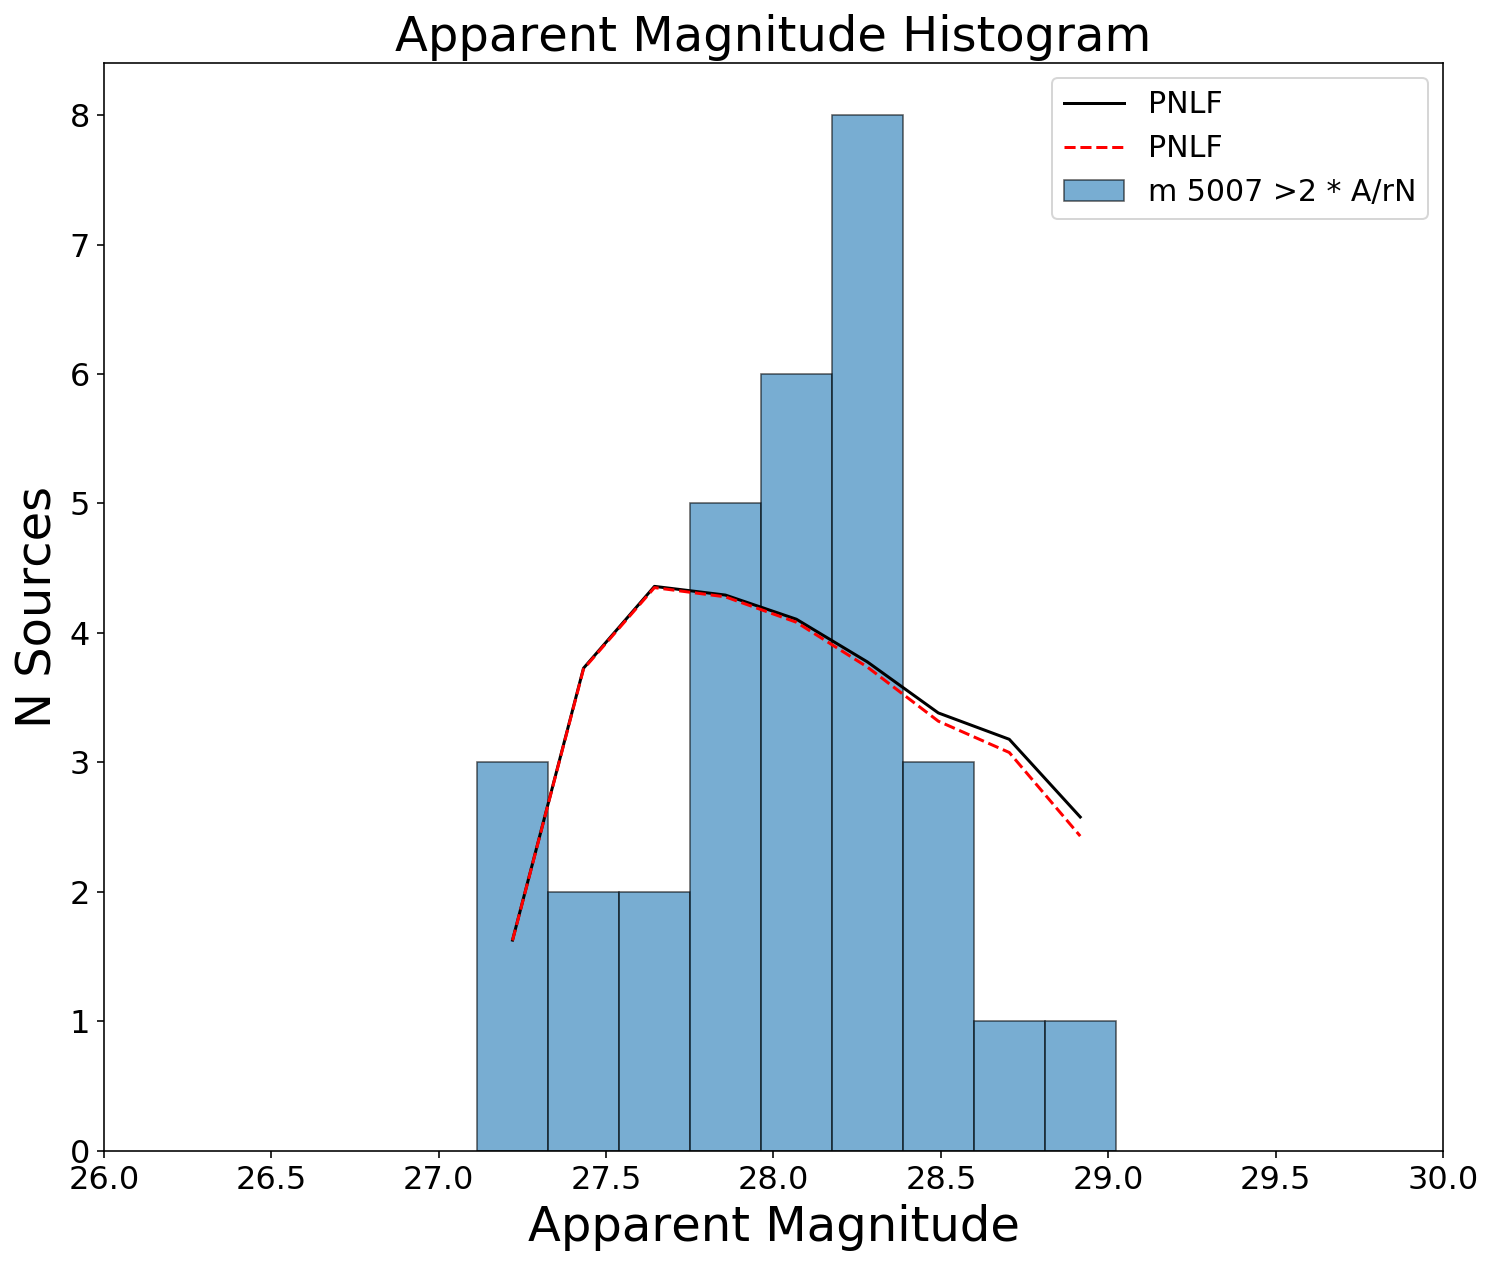

In [39]:
plt.figure(2, figsize=(12,10))
info = plt.hist(PNe_df["m 5007"].loc[PNe_df["A/rN"]>2], bins=len(bins), edgecolor="black", linewidth=0.8, label="m 5007 >2 * A/rN", alpha=0.6)
#plt.hist(PNe_df["M 5007"].loc[PNe_df["A/rN"]<2], bins=4, edgecolor="black",linewidth=0.8, color="red", alpha=0.5, label="M 5007 <2 * A/rN")
ax = plt.gca()
plt.xlim(26.,30.0)
#plt.yticks(np.arange(0,22,2), np.arange(0,22,2))
plt.title("Apparent Magnitude Histogram", fontsize=24)
plt.xlabel("Apparent Magnitude", fontsize=24)
plt.ylabel("N Sources", fontsize=24)
ax.get_yticklabels()
ax.tick_params(labelsize=18)
ax.tick_params(labelsize=16)
#plt.savefig("Plots/FCC255/M5007 histogram.png")

PNLF = results.params["c1"].value*(np.exp(np.abs(results.params["c2"].value)*PNe_df["m 5007"])) * (1-np.exp(3*((PNe_df["m 5007"].min() - PNe_df["m 5007"]))))
#PNLF = (PNLF * results.params["a"]) 
#plt.scatter(PNe_df["M 5007"].loc[PNe_df["M 5007"]>-5], PNLF, c="k")


binned_PNLF = np.zeros(len(bins_cens))
for i in np.arange(1,len(bins_cens)+1):
    binned_PNLF[i-1] = np.mean(PNLF_df["PNLF"].loc[PNLF_df["binned_values"]==i])
    
print(binned_PNLF)
plt.plot(bins_cens_right, (binned_PNLF), color="k", label="PNLF" )
plt.plot(bins_cens_right, (binned_PNLF) * ratio_counter, color="r", ls="--", label="PNLF" )
plt.legend(fontsize=15)
plt.savefig("Plots/FCC255/PNLF.png")

## Error estimation

In [19]:
def MUSE_3D_err(params, l, x_2D, y_2D, data):
    moffat_amp = params['A_err']
    x_0 = params['x_err']
    y_0 = params['y_err']
    FWHM = params['FWHM_err']
    beta = params["beta_err"]
    wave = params["wave_err"]
    Gauss_FWHM = params["Gauss_FWHM_err"]
    Gauss_bkg = params["Gauss_bkg_err"]
    Gauss_grad = params["Gauss_grad_err"]
    
    #Moffat model
    gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((np.array(x_2D) - x_0)**2 + (np.array(y_2D) - y_0)**2) / gamma**2
    F_OIII_xy = moffat_amp * (1 + rr_gg)**(-beta)
    
    comb_FWHM = np.sqrt(2.81**2 + Gauss_FWHM**2)
    Gauss_std = comb_FWHM / 2.35482
    
    # Convert Moffat flux to amplitude
    A_OIII_xy = ((F_OIII_xy) / (np.sqrt(2*np.pi) * Gauss_std))
    
    #Construct model gaussian profiles for each amplitude value in cube
    model_spectra = [(Gauss_bkg + (Gauss_grad * l) + np.abs(Amp) * np.exp(- 0.5 * (l - wave)** 2 / Gauss_std**2.) +
             (np.abs(Amp)/3.0) * np.exp(- 0.5 * (l - (wave - 47.9399))** 2 / Gauss_std**2.)) for Amp in A_OIII_xy]
    
    return np.sum(F_OIII_xy * 1e-20)

high_F_list = np.zeros(len(x_PNe))
low_F_list = np.zeros(len(x_PNe))

for num in np.arange(0, len(x_PNe)):
    error_params_add = Parameters()
    error_params_add.add("A_err", value=M_amp_list[num] + moff_A_err[num], vary=False)
    error_params_add.add("x_err", value=list_of_x[num] + x_0_err[num], vary=False)
    error_params_add.add("y_err", value=list_of_y[num] + y_0_err[num], vary=False)
    error_params_add.add("FWHM_err", value=PNe_params["FWHM"].value + FWHM_in_err, vary=False)
    error_params_add.add("beta_err", value=PNe_params["beta"].value + beta_in_err, vary=False)
    error_params_add.add("wave_err", value=mean_wave_list[num] + mean_wave_err[num], vary=False)
    error_params_add.add("Gauss_FWHM_err", value=PNe_params["Gauss_FWHM"].value + 0.0, vary=False)
    error_params_add.add("Gauss_bkg_err", value=Gauss_bkg[num] + Gauss_bkg_err[num], vary=False)
    error_params_add.add("Gauss_grad_err", value=Gauss_grad[num] + Gauss_grad_err[num], vary=False)
    
    error_params_minus = Parameters()
    error_params_minus.add("A_err", value=M_amp_list[num] - moff_A_err[num], vary=False)
    error_params_minus.add("x_err", value=list_of_x[num] - x_0_err[num], vary=False)
    error_params_minus.add("y_err", value=list_of_y[num] - y_0_err[num], vary=False)
    error_params_minus.add("FWHM_err", value=PNe_params["FWHM"].value - FWHM_in_err, vary=False)
    error_params_minus.add("beta_err", value=PNe_params["beta"].value - beta_in_err, vary=False)
    error_params_minus.add("wave_err", value=mean_wave_list[num] - mean_wave_err[num], vary=False)
    error_params_minus.add("Gauss_FWHM_err", value=PNe_params["Gauss_FWHM"].value - 0.0, vary=False)
    error_params_minus.add("Gauss_bkg_err", value=Gauss_bkg[num] - Gauss_bkg_err[num], vary=False)
    error_params_minus.add("Gauss_grad_err", value=Gauss_grad[num] - Gauss_grad_err[num], vary=False)
    
    model_add = MUSE_3D_err(error_params_add, wavelength, x_fit, y_fit, PNe_spectra[num])
    high_F_list[num] = model_add
    model_minus = MUSE_3D_err(error_params_minus, wavelength, x_fit, y_fit, PNe_spectra[num])
    low_F_list[num] = model_minus

delta_F_high = high_F_list - PNe_df["Total Flux"]
delta_F_low = PNe_df["Total Flux"] - low_F_list

PNe_df["Flux error"] = np.median((delta_F_high, delta_F_low))

PNe_df["M 5007 error"] = 1.09 * (PNe_df["Flux error"] / PNe_df["Total Flux"])

# Load in saved data

In [4]:
# Pull out the 1D flux data from 1D fits to do radial comparison
gauss_1D_A = np.load("exported_data/FCC277/gauss_A_cen.npy")
A_rN_plot = np.load("exported_data/FCC277/A_rN_cen.npy")

Flux_1D = gauss_1D_A * np.sqrt(2*np.pi) * 1.19
Flux_1D_cube = Flux_1D.reshape(y_data, x_data)
A_rN_plot_shape = A_rN_plot.reshape(y_data, x_data)

PNe_1D_flux_data = np.array([PNextractor(x, y, n_pixels, Flux_1D_cube, dim=1.0) for x,y in zip(x_PNe,y_PNe)])
PNe_1D_A_rN_data = np.array([PNextractor(x, y, n_pixels, A_rN_plot_shape, dim=1.0) for x,y in zip(x_PNe,y_PNe)])

## Flux and A/rN maps, with circled sources

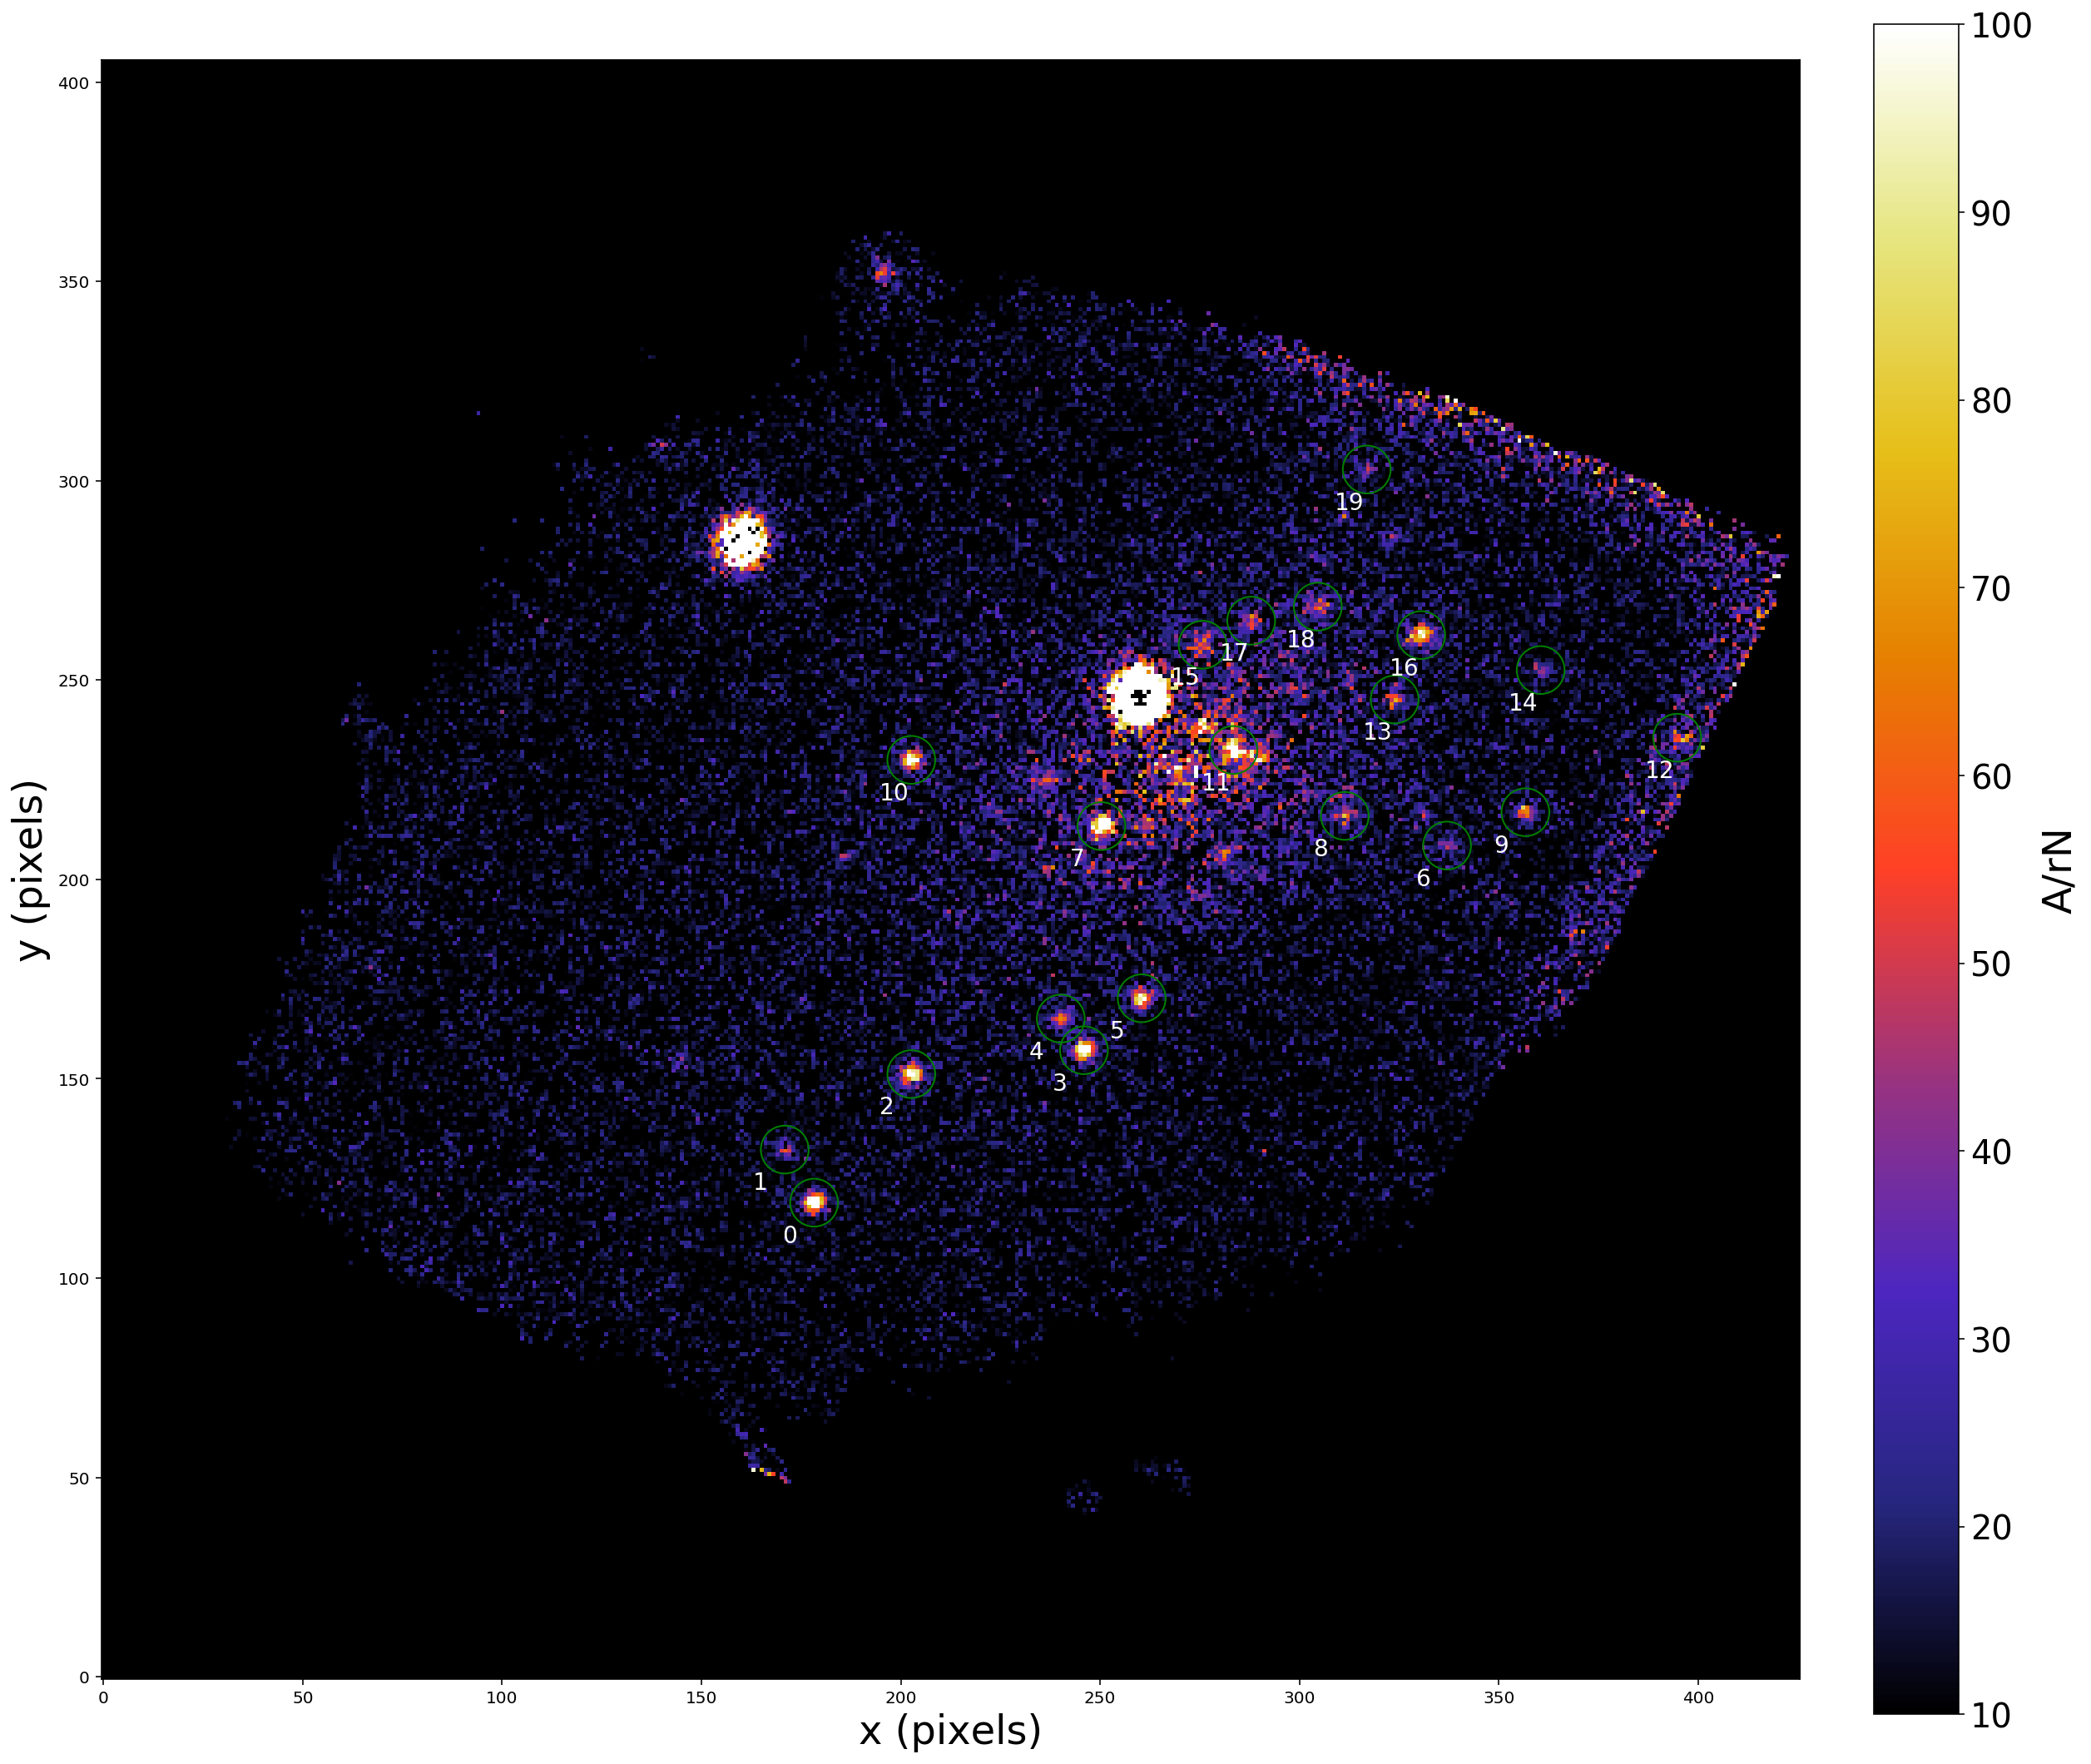

In [6]:
plt.figure(figsize=(20,20))
plt.imshow(Flux_1D_cube, origin="lower", cmap="CMRmap", vmin=10, vmax=100)
ax = plt.gca()
cb=plt.colorbar(fraction=0.0455, pad=0.04)
cb.set_label("A/rN",fontsize=24)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=20)
plt.xlabel("x (pixels)", fontsize=24)
plt.ylabel("y (pixels)", fontsize=24)
#circ_r = plt.Circle((x_data/2.,y_data/2.), 80, color="white", fill=False)
#ax.add_artist(circ_r)
for i, item in enumerate(x_y_list):
    ax = plt.gca()
    circ = plt.Circle((item[0],item[1]),6, color="green", fill=False)
    ax.add_artist(circ)
    ax.annotate(i, (item[0]-8, item[1]-10), color="white", size=14)


plt.savefig("Plots/FCC277/ArN_circled_map.png")

# Velocity vs M_{5007}

(-5, 0)

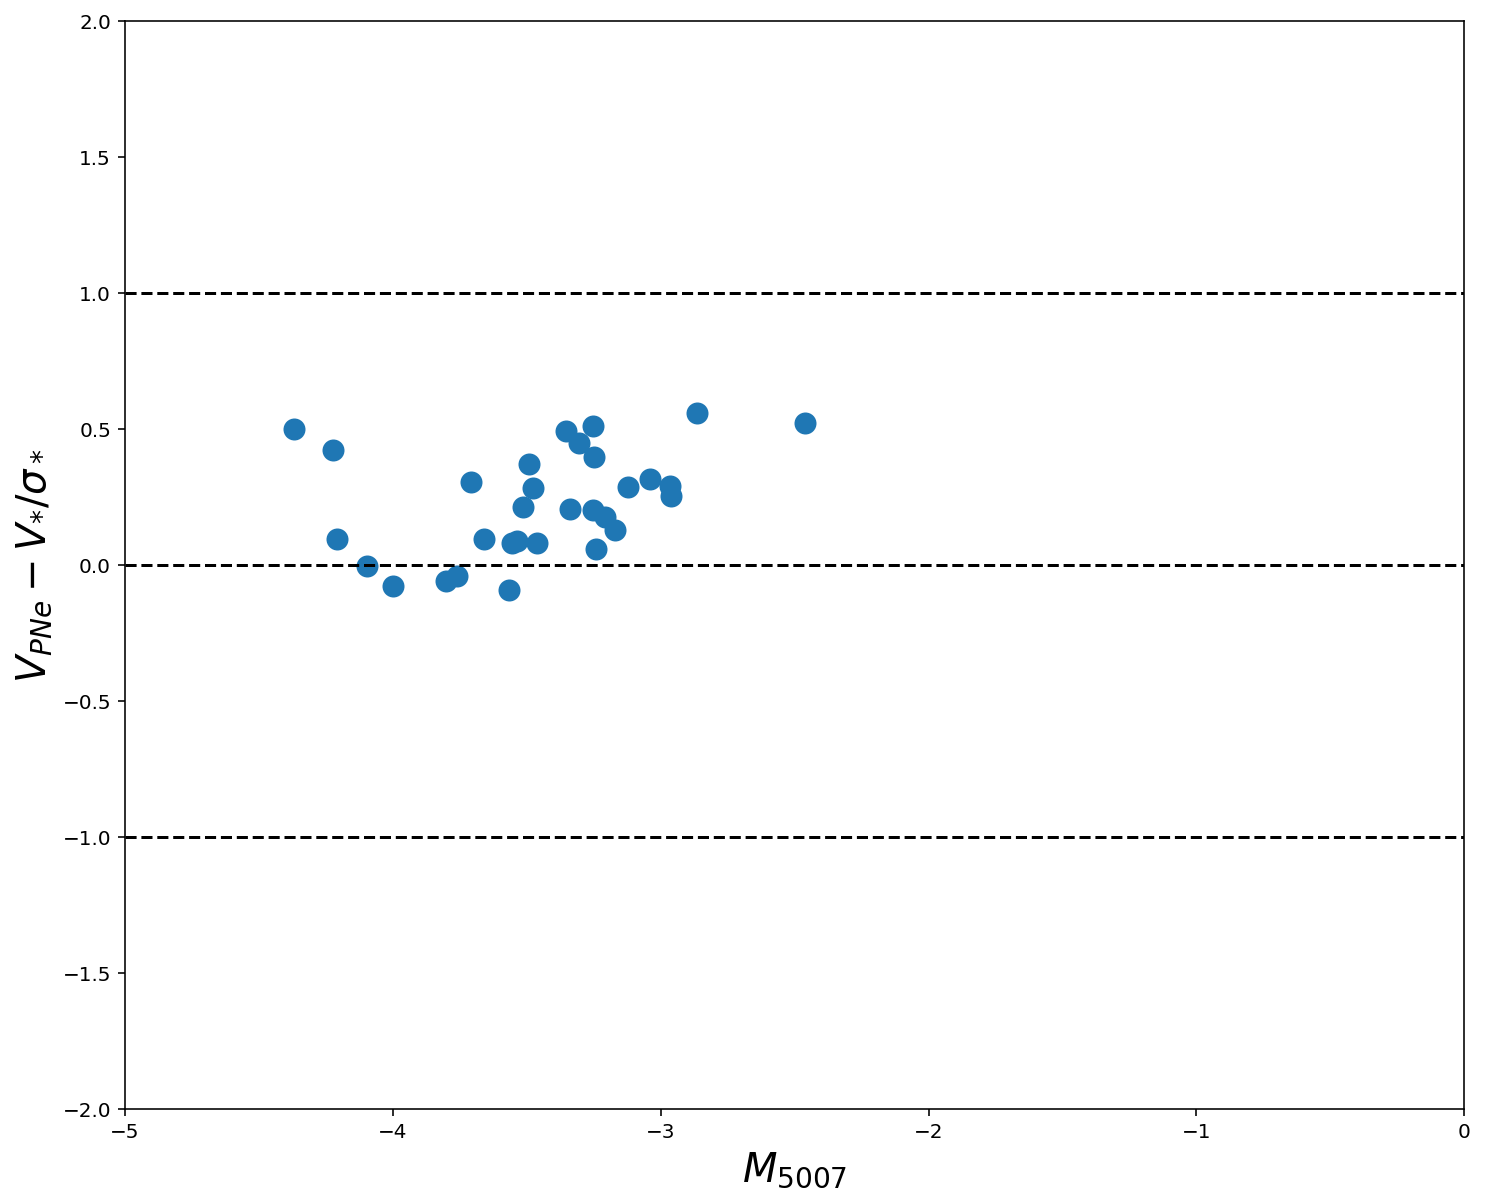

In [40]:
#%% Work on stellar dispersion comparison plot
stellar_vel = 0. # km/s
stellar_dis = 240. # km/s
PNe_vel_ratio = (PNe_df["V (km/s)"].loc[PNe_df["A/rN"]>3.] - stellar_vel)/ stellar_dis

plt.figure(44, figsize=(12,10))
plt.clf()
plt.scatter(PNe_df["M 5007"].loc[PNe_df["A/rN"]>3.], PNe_vel_ratio, s=100)
plt.xlabel("$M_{5007}$", fontsize=20)
plt.ylabel("$V_{PNe} - V_{*} / \sigma_*$", fontsize=20)
plt.axhline(y=1, c="k", ls="dashed")
plt.axhline(y=0, c="k", ls="dashed")
plt.axhline(y=-1, c="k", ls="dashed")
plt.ylim(-2,2)
plt.xlim(-5,0)

# MCMC routine


In [147]:
MCMC_df = pd.DataFrame(columns=("PNe number", "Total Flux", "Flux error", "V (km/s)", "m 5007", "M 5007", "M 5007 error","A/rN","stddev", "FWHM", "beta"))
MCMC_df["PNe number"] = np.arange(1,len(x_PNe)+1)

In [ ]:
%%time
# Using MCMC from LMFit, with emcee to fit sources, will need work done before running

def lnprob(params, data, error, num):
    noise = params["f"]
    res = MUSE_3D_residual(params, wavelength, x_fit, y_fit, data, error, num, useful_stuff)
    return -0.5 * np.sum((res / noise)**2 + np.log(2 * np.pi * noise**2))

# Use minimization results from above

MCMC_moff_amp = np.zeros(len(x_PNe))
MCMC_gamma = np.zeros(len(x_PNe))
MCMC_beta = np.zeros(len(x_PNe))
MCMC_params = np.zeros((len(x_PNe),10))


# add a noise parameter and run MCMC for each run from results_for_MCMC
for PNe_num in np.arange(26,27):#, len(x_PNe)):
    useful_stuff = []
    run_mini = minimize(MUSE_3D_residual, params, args=(wavelength, x_fit, y_fit, PNe_spectra[PNe_num], error_cube[PNe_num], PNe_num, useful_stuff), nan_policy="propagate")
    mini_result = run_mini
    #add noise parameter
    mini_result.params.add('f', value=1, min=0.001, max=2)
    mini_lnprob = Minimizer(lnprob, mini_result.params, fcn_args=(PNe_spectra[PNe_num], error_cube[PNe_num], PNe_num))
    # Run MCMC routine
    MCMC_results = mini_lnprob.emcee(nwalkers=20, burn=400, steps=1500, thin=8, workers=3, params=mini_result.params)
    # store results
    MCMC_df.loc[PNe_num, "FWHM"] = MCMC_results.params["FWHM"].value
    MCMC_df.loc[PNe_num, "beta"] = MCMC_results.params["beta"].value
    MCMC_df.loc[PNe_num, "stddev"] = MCMC_results.params["Gauss_std"].value
    MCMC_df.loc[PNe_num, "Total Flux"] = useful_stuff[0][0]
    MCMC_df.loc[PNe_num, "V (km/s)"] = (c * (MCMC_results.params["wave"] - 5006.8) / 5006.8) / 1000
    #list_of_best_stddev[PNe_num] = MCMC_results.params["Gauss_std"]
    #list_of_residuals[PNe_num] = useful_stuff[0][1]
    #list_of_A_OIII[PNe_num] = useful_stuff[0][2]
    #list_of_F_OIII_xy[PNe_num] = useful_stuff[0][3]
    #list_of_M_amp[PNe_num] = MCMC_results.params["moffat_amp"]
    #list_of_x[PNe_num] = MCMC_results.params["x_0"]
    #list_of_y[PNe_num] = MCMC_results.params["y_0"]
    #list_of_means[PNe_num] = MCMC_results.params["mean"]
    #list_of_g_bkg[PNe_num] = MCMC_results.params["Gauss_bkg"]
    #list_of_g_grad[PNe_num] = MCMC_results.params["Gauss_grad"]
    #save errors
    #moff_A_err[PNe_num] = results.params["moffat_amp"].stderr
    #x_0_err[PNe_num] = results.params["x_0"].stderr
    #y_0_err[PNe_num] = results.params["y_0"].stderr
    #mean_err[PNe_num] = results.params["mean"].stderr
    #g_bkg_err[PNe_num] = results.params["Gauss_bkg"].stderr
    #g_grad_err[PNe_num] = results.params["Gauss_grad"].stderr
    #h.value += 1
    
A_by_rN = list_of_A_OIII / list_of_residuals
PNe_df["A/rN"] = A_by_rN

def log_10(x):
    return np.log10(x)

MCMC_df["m 5007"] = -2.5 * MCMC_df["Total Flux"].apply(log_10) - 13.74
dM = 31.28 #5. * np.log10(16.4) + 25
MCMC_df["M 5007"] = MCMC_df["m 5007"] - dM

# PSF Fitter - Simultaneous fitter

In [ ]:
# Single Run PSF Fitter
#sel_PNe = PNe_df.nsmallest(2, "m 5007").index.values
sel_PNe = [5]#,62]#63,26]#[ 28]#, 29]
print(sel_PNe)

selected_PNe = PNe_spectra[sel_PNe]
selected_PNe_err = obj_error_cube[sel_PNe] 
PSF_params = Parameters()

def model_params(p, n, amp, wave):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp, min=0.001)
    PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("wave_{:03d}".format(n), value=wave, min=5000., max=5070.)
    PSF_params.add("gauss_bkg_{:03d}".format(n), value=0.001)
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.001)


for i in np.arange(0,len(sel_PNe)):
        model_params(p=PSF_params, n=i, amp=200.0, wave=5030.0)    
    
PSF_params.add('FWHM', value=4.0, min=0.01, max=12., vary=True)
PSF_params.add("beta", value=4.0, min=0.01, max=12., vary=True) 

PSF_results = minimize(PSF_residuals, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err), nan_policy="propagate")

print("FWHM: ",PSF_results.params["FWHM"].value, "+/-", PSF_results.params["FWHM"].stderr, "({:3.2f}%)".format((PSF_results.params["FWHM"].stderr/PSF_results.params["FWHM"].value)*100) )
print("Beta: ",PSF_results.params["beta"].value, "+/-", PSF_results.params["beta"].stderr, "({:3.2f}%)".format((PSF_results.params["beta"].stderr/PSF_results.params["beta"].value)*100) )
print(report_fit(PSF_results))

# PSF fitting evaluation over individual fittings

In [45]:
num_psf = len(x_PNe)
n_brightest = PNe_df.nlargest(num_psf, "A/rN").index.values
fitted_FWHM = np.zeros(num_psf)
fitted_beta = np.zeros(num_psf)
rad_sel = np.zeros(num_psf)
fitted_G_FWHM = np.zeros(num_psf)

#params = Parameters()
def model_params(p, n, amp, wave):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp, min=0.001)
    PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("wave_{:03d}".format(n), value=wave, min=4990., max=5060.)
    PSF_params.add("gauss_bkg_{:03d}".format(n), value=0.001)
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.00001)


for i in np.arange(0, num_psf):
    sel_PNe = [n_brightest[i]]
    selected_PNe = PNe_spectra[sel_PNe]
    selected_PNe_err = obj_error_cube[sel_PNe]
    PSF_params = Parameters()
    model_params(p=PSF_params, n=0, amp=100.0, wave=5030.0)
    PSF_params.add('FWHM', value=2.0, min=0.001, max=8., vary=True)
    PSF_params.add("beta", value=4.0, min=0.001, max=8., vary=True) 
    PSF_params.add("Gauss_FWHM", value=0.0001, min=0.0000001, max=5.0, vary=False)
    rad_sel[i] = PNe_df.iloc[sel_PNe]["rad D"]
    results = minimize(PSF_residuals, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err, [1.]), nan_policy="propagate")
    fitted_FWHM[i] = results.params["FWHM"].value
    fitted_beta[i] = results.params["beta"].value
    fitted_G_FWHM[i] = results.params["Gauss_FWHM"].value
    


In [ ]:
def straight_res(params, x, data):
    m = params["m"]
    c = params["c"]
    y = m*x + c
    return data - y

straight_params = Parameters()
straight_params.add("m", value=0.1)
straight_params.add("c", value=0.1)

straight_results = minimize(straight_res, straight_params, args=(rad_sel, fitted_beta))
m = straight_results.params["m"].value
c = straight_results.params["c"].value
report_fit(straight_results)

NameError: name 'm' is not defined

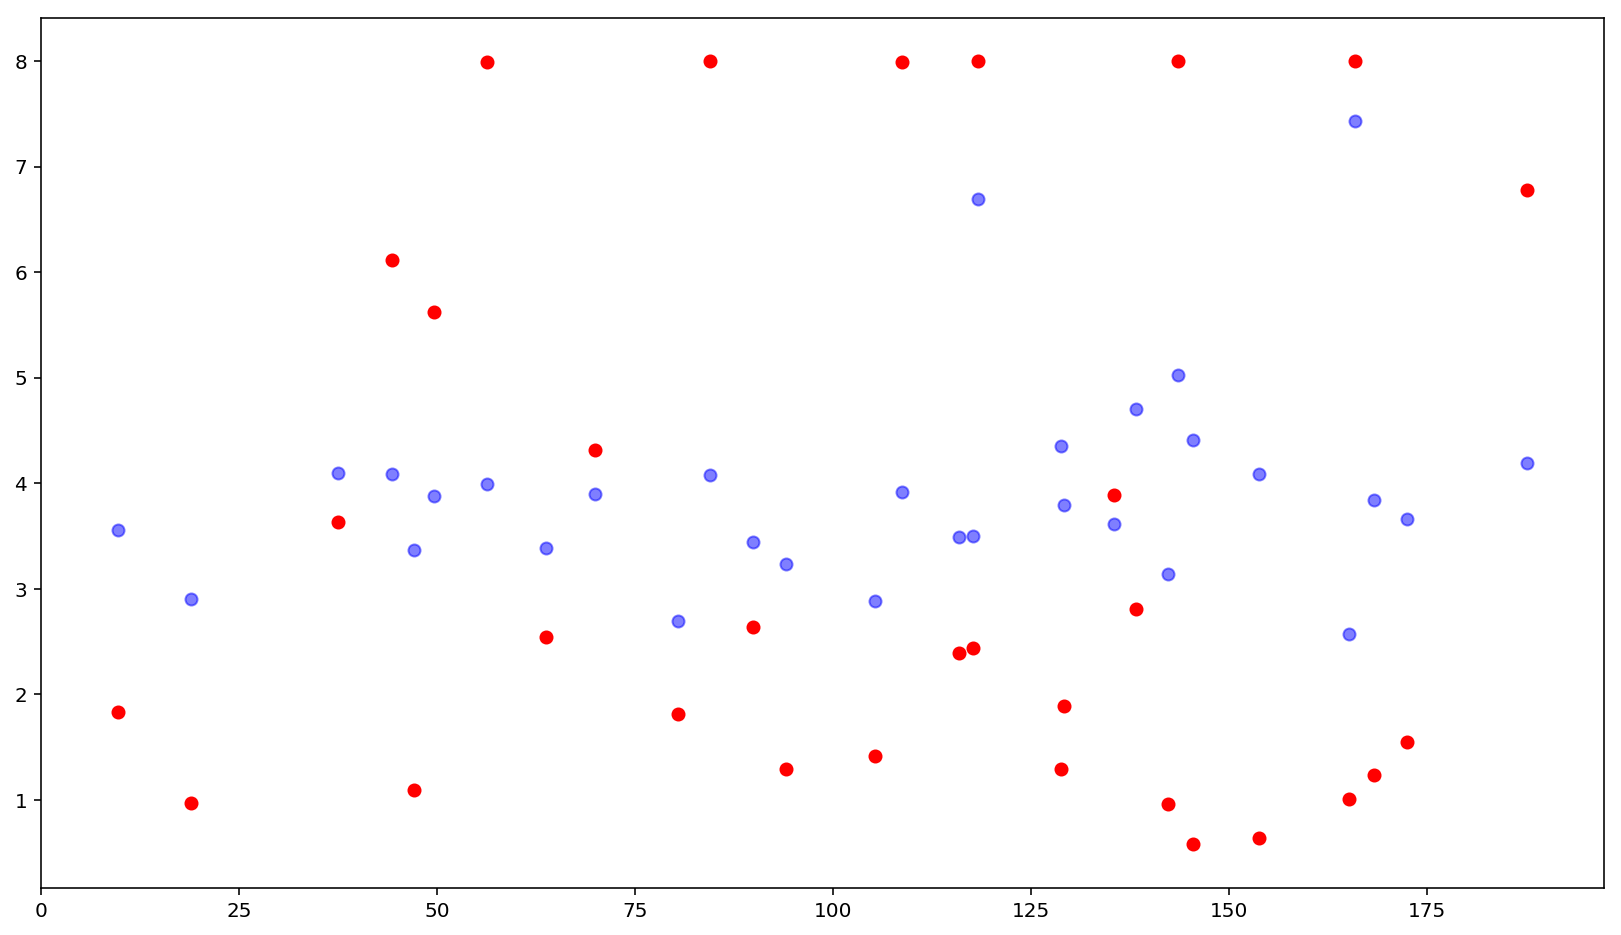

In [46]:
plt.figure(figsize=(14,8))
plt.scatter(rad_sel, fitted_FWHM, label="FWHM", c="blue", alpha=0.5)
plt.scatter(rad_sel, fitted_beta, label="beta", c="red")
plt.plot(rad_sel, (m*rad_sel + c), label="Best beta fit", c="r")
#plt.scatter(rad_sel, fitted_G_FWHM, label="G_FWHM", c="k" )
plt.xlabel("Radial Distance from centre (pixels)", fontsize=20)
plt.ylabel("FWHM (Blue) and Beta (Red)", fontsize=20)
plt.ylim(-0.1,8.1)
plt.grid()

plt.axhline(np.median(fitted_FWHM[:50]), label="FWHM median", ls="dashed", c="blue")
plt.axhline(np.median(fitted_beta[:50]), label="Beta median", ls="dashed", c="red")
#plt.axhline(np.median(fitted_G_FWHM), label="G_FWHM median", ls="dashed", c="k")

print(np.median(fitted_beta[:20]))
print(np.median(fitted_FWHM[:20]))
plt.legend()
plt.savefig("Plots/FCC255/radial_FWHM_beta.png")

# PSF Fitting - Evaluation with differing number of simultaneous PNe fitted

In [47]:
num_psf=6
fitted_FWHM = np.zeros(num_psf)
fitted_beta = np.zeros(num_psf)
A_rN_total = np.zeros(num_psf)
fitted_G_FWHM = np.zeros(num_psf)
fitted_moff_amp = [[]]*num_psf
fitted_x = [[]]*num_psf
fitted_y = [[]]*num_psf

#params = Parameters()
def model_params(p, n, amp, wave):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp, min=0.001)
    PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("wave_{:03d}".format(n), value=wave, min=5000., max=5070.)
    PSF_params.add("gauss_bkg_{:03d}".format(n), value=0.01)
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.01)
    
for j in np.arange(0, num_psf):
    sel_PNe = PNe_df.nlargest(j+1, "A/rN").index.values
    selected_PNe = PNe_spectra[sel_PNe]
    selected_PNe_err = obj_error_cube[sel_PNe]
    PSF_params = Parameters()
    for i in np.arange(0,len(sel_PNe)):
        model_params(p=PSF_params, n=i, amp=200.0, wave=5035.0)
    PSF_params.add('FWHM', value=2.0, min=0.01, max=12., vary=True)
    PSF_params.add("beta", value=1.0, min=0.01, max=12., vary=True) 
    PSF_params.add("Gauss_FWHM", value=0.0001, min=0.00001, max=3.0, vary=False)
    A_rN_total[j] = np.sqrt(np.sum(PNe_df.iloc[sel_PNe]["A/rN"]**2.))
    A_rN_of_PNe = np.ones(len(sel_PNe))#PNe_df.iloc[sel_PNe]["A/rN"].values
    results = minimize(PSF_residuals, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err, A_rN_of_PNe), nan_policy="propagate")#, method="differential_evolution")
    fitted_FWHM[j] = results.params["FWHM"].value
    fitted_beta[j] = results.params["beta"].value
    fitted_G_FWHM[j] = results.params["Gauss_FWHM"].value
    #for k in np.arange(0, len(sel_PNe)):
    #    fitted_moff_amp.append(results.params["moffat_amp_{:03d}".format(k)].value)
    #    fitted_x.append(results.params["x_{:03d}".format(k)].value)
    #    fitted_y.append(results.params["y_{:03d}".format(k)].value)

    

3.7517099661277378
2.485676160679091


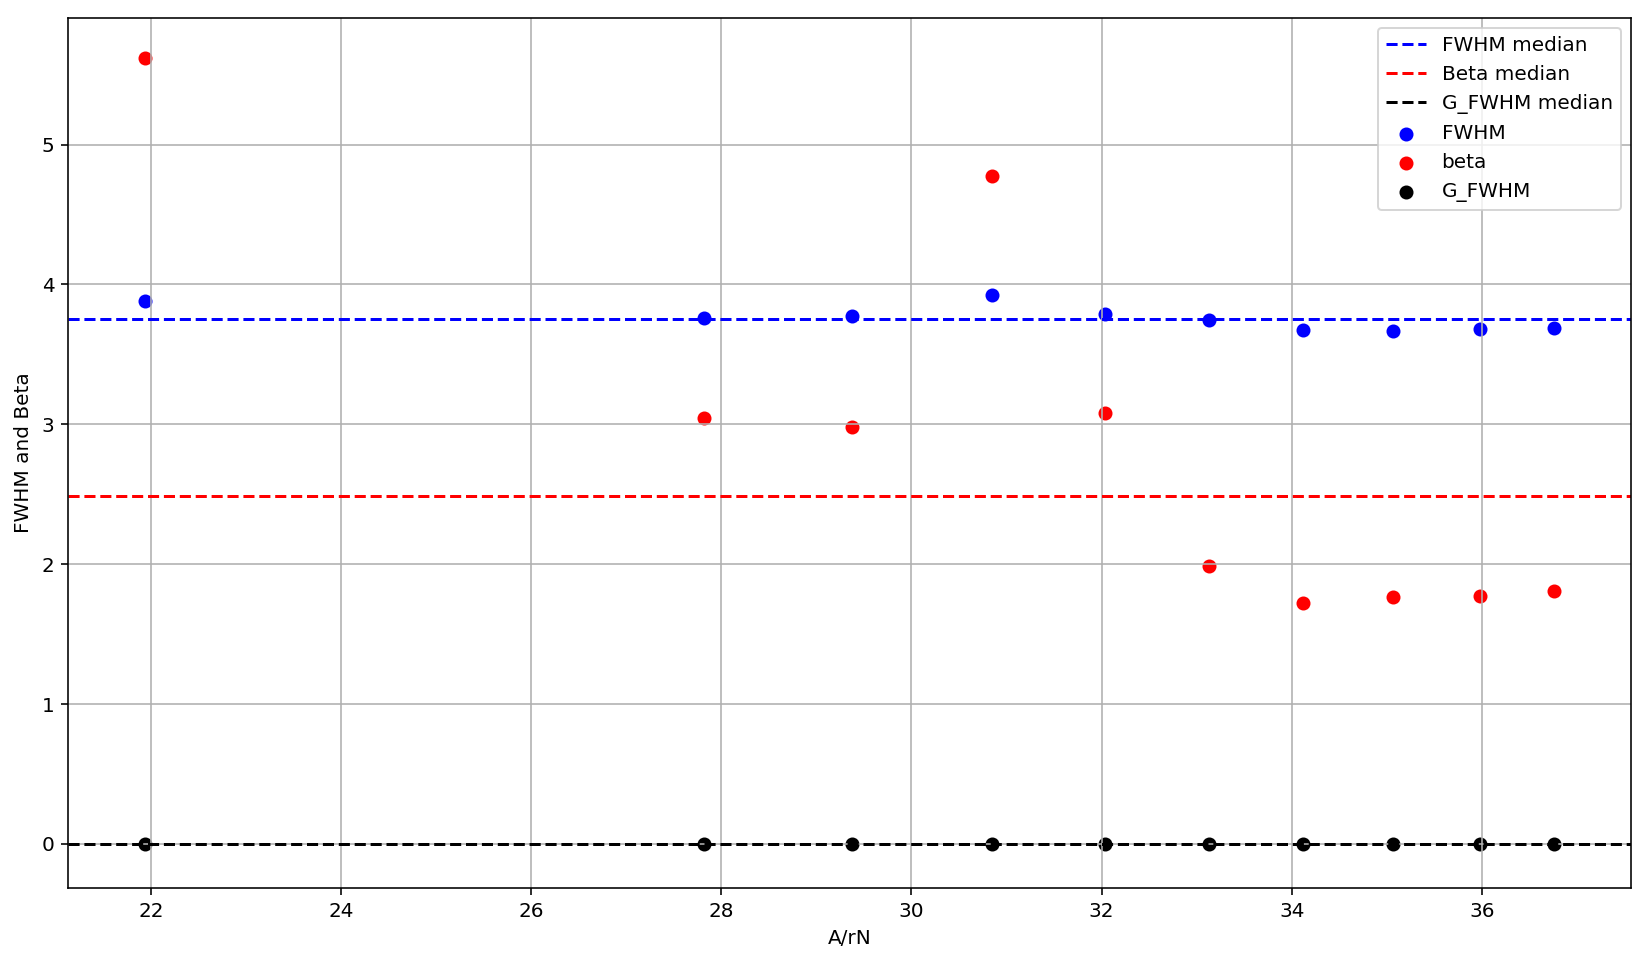

In [48]:
plt.figure(figsize=(14,8))
plt.scatter(A_rN_total, fitted_FWHM, label="FWHM", c="blue")
plt.scatter(A_rN_total, fitted_beta, label="beta", c="red")
plt.scatter(A_rN_total, fitted_G_FWHM, label="G_FWHM", c="k" )
plt.xlabel("A/rN")
plt.ylabel("FWHM and Beta")
plt.grid()

plt.axhline(np.median(fitted_FWHM[:]), label="FWHM median", ls="dashed", c="blue")
plt.axhline(np.median(fitted_beta[:]), label="Beta median", ls="dashed", c="red")
plt.axhline(np.median(fitted_G_FWHM[:]), label="G_FWHM median", ls="dashed", c="k")

print(np.median(fitted_FWHM[:]))
print(np.median(fitted_beta[:]))
      
plt.legend()
#plt.savefig("Plots/FCC255/PSF_A_rN_FWHM_beta.png")

# MCMC PSF fitter

In [4]:
# MCMC
sel_PNe = [0]# PNe_df.nlargest(1, "A/rN").index.values

selected_PNe = PNe_spectra[sel_PNe]
selected_PNe_err = obj_error_cube[sel_PNe] 

PSF_params = Parameters()
def model_params(p, n, amp, wave):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp, min=0.001)
    PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("wave_{:03d}".format(n), value=wave, min=wave-40., max=wave+40.)
    PSF_params.add("gauss_bkg_{:03d}".format(n), value=0.001)
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.001)

for i in np.arange(0,len(sel_PNe)):
        model_params(p=PSF_params, n=i, amp=100.0, wave=5030.0)   
    
PSF_params.add('FWHM', value=4.0, min=0.01, max=12., vary=True)
PSF_params.add("beta", value=4.0, min=0.01, max=12., vary=True) 

def lnprob(p, data, error):
    noise = p["f"]
    res = PSF_residuals(p, wavelength, x_fit, y_fit, data, error)
    return -0.5 * np.sum((res / noise)**2 + np.log(2 * np.pi * noise**2))

# add a noise parameter and run MCMC for each run from results_for_MCMC
run_mini = minimize(PSF_residuals, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err), nan_policy="propagate")
print("Initial fit complete.")
#add noise parameter
run_mini.params.add('f', value=1., min=0.001, max=2.)
print("Nuisance Parameter added.")
mini_lnprob = Minimizer(lnprob, run_mini.params, fcn_args=(selected_PNe, selected_PNe_err))
print("Minimizer ready.")
# Run MCMC routine
print("All aboard the MCMC train.")
MCMC_results = mini_lnprob.emcee(nwalkers=100, burn=300, steps=2000, thin=20, workers=3, is_weighted=True, params=run_mini.params)

print("FWHM: " , MCMC_results.params["FWHM"].value, MCMC_results.params["FWHM"].stderr)
print("Beta: " , MCMC_results.params["beta"].value, MCMC_results.params["beta"].stderr)

Initial fit complete.
Nuisance Parameter added.
Minimizer ready.
All aboard the MCMC train.
FWHM:  4.066435824459834 0.07190633291700532
Beta:  2.958117317658016 0.48035600095169095


In [11]:
report_fit(MCMC_results)

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 0
    # data points      = unknown
    # variables        = 9
    chi-square         = unknown
    reduced chi-square = unknown
    Akaike info crit   = unknown
    Bayesian info crit = unknown
[[Variables]]
    moffat_amp_000:  227.527591 +/- 0.04449577 (0.02%) (init = 227.5283)
    x_000:           4.67420900 +/- 3.4989e-04 (0.01%) (init = 4.674194)
    y_000:           4.99569499 +/- 3.5229e-04 (0.01%) (init = 4.995692)
    mean_000:        5029.96038 +/- 1.9706e-04 (0.00%) (init = 5029.96)
    gauss_bkg_000:   6.7518e-04 +/- 1.1650e-05 (1.73%) (init = 0.0006752691)
    gauss_grad_000: -3.28401606 +/- 0.05844826 (1.78%) (init = -3.284454)
    FWHM:            3.87802385 +/- 9.8073e-04 (0.03%) (init = 3.878)
    beta:            5.60905018 +/- 0.02430910 (0.43%) (init = 5.608406)
    Gauss_FWHM:      1e-05 (fixed)
    f:               1.99999997 +/- 3.9049e-08 (0.00%) (init = 1)
[[Correlations]] (unreported co

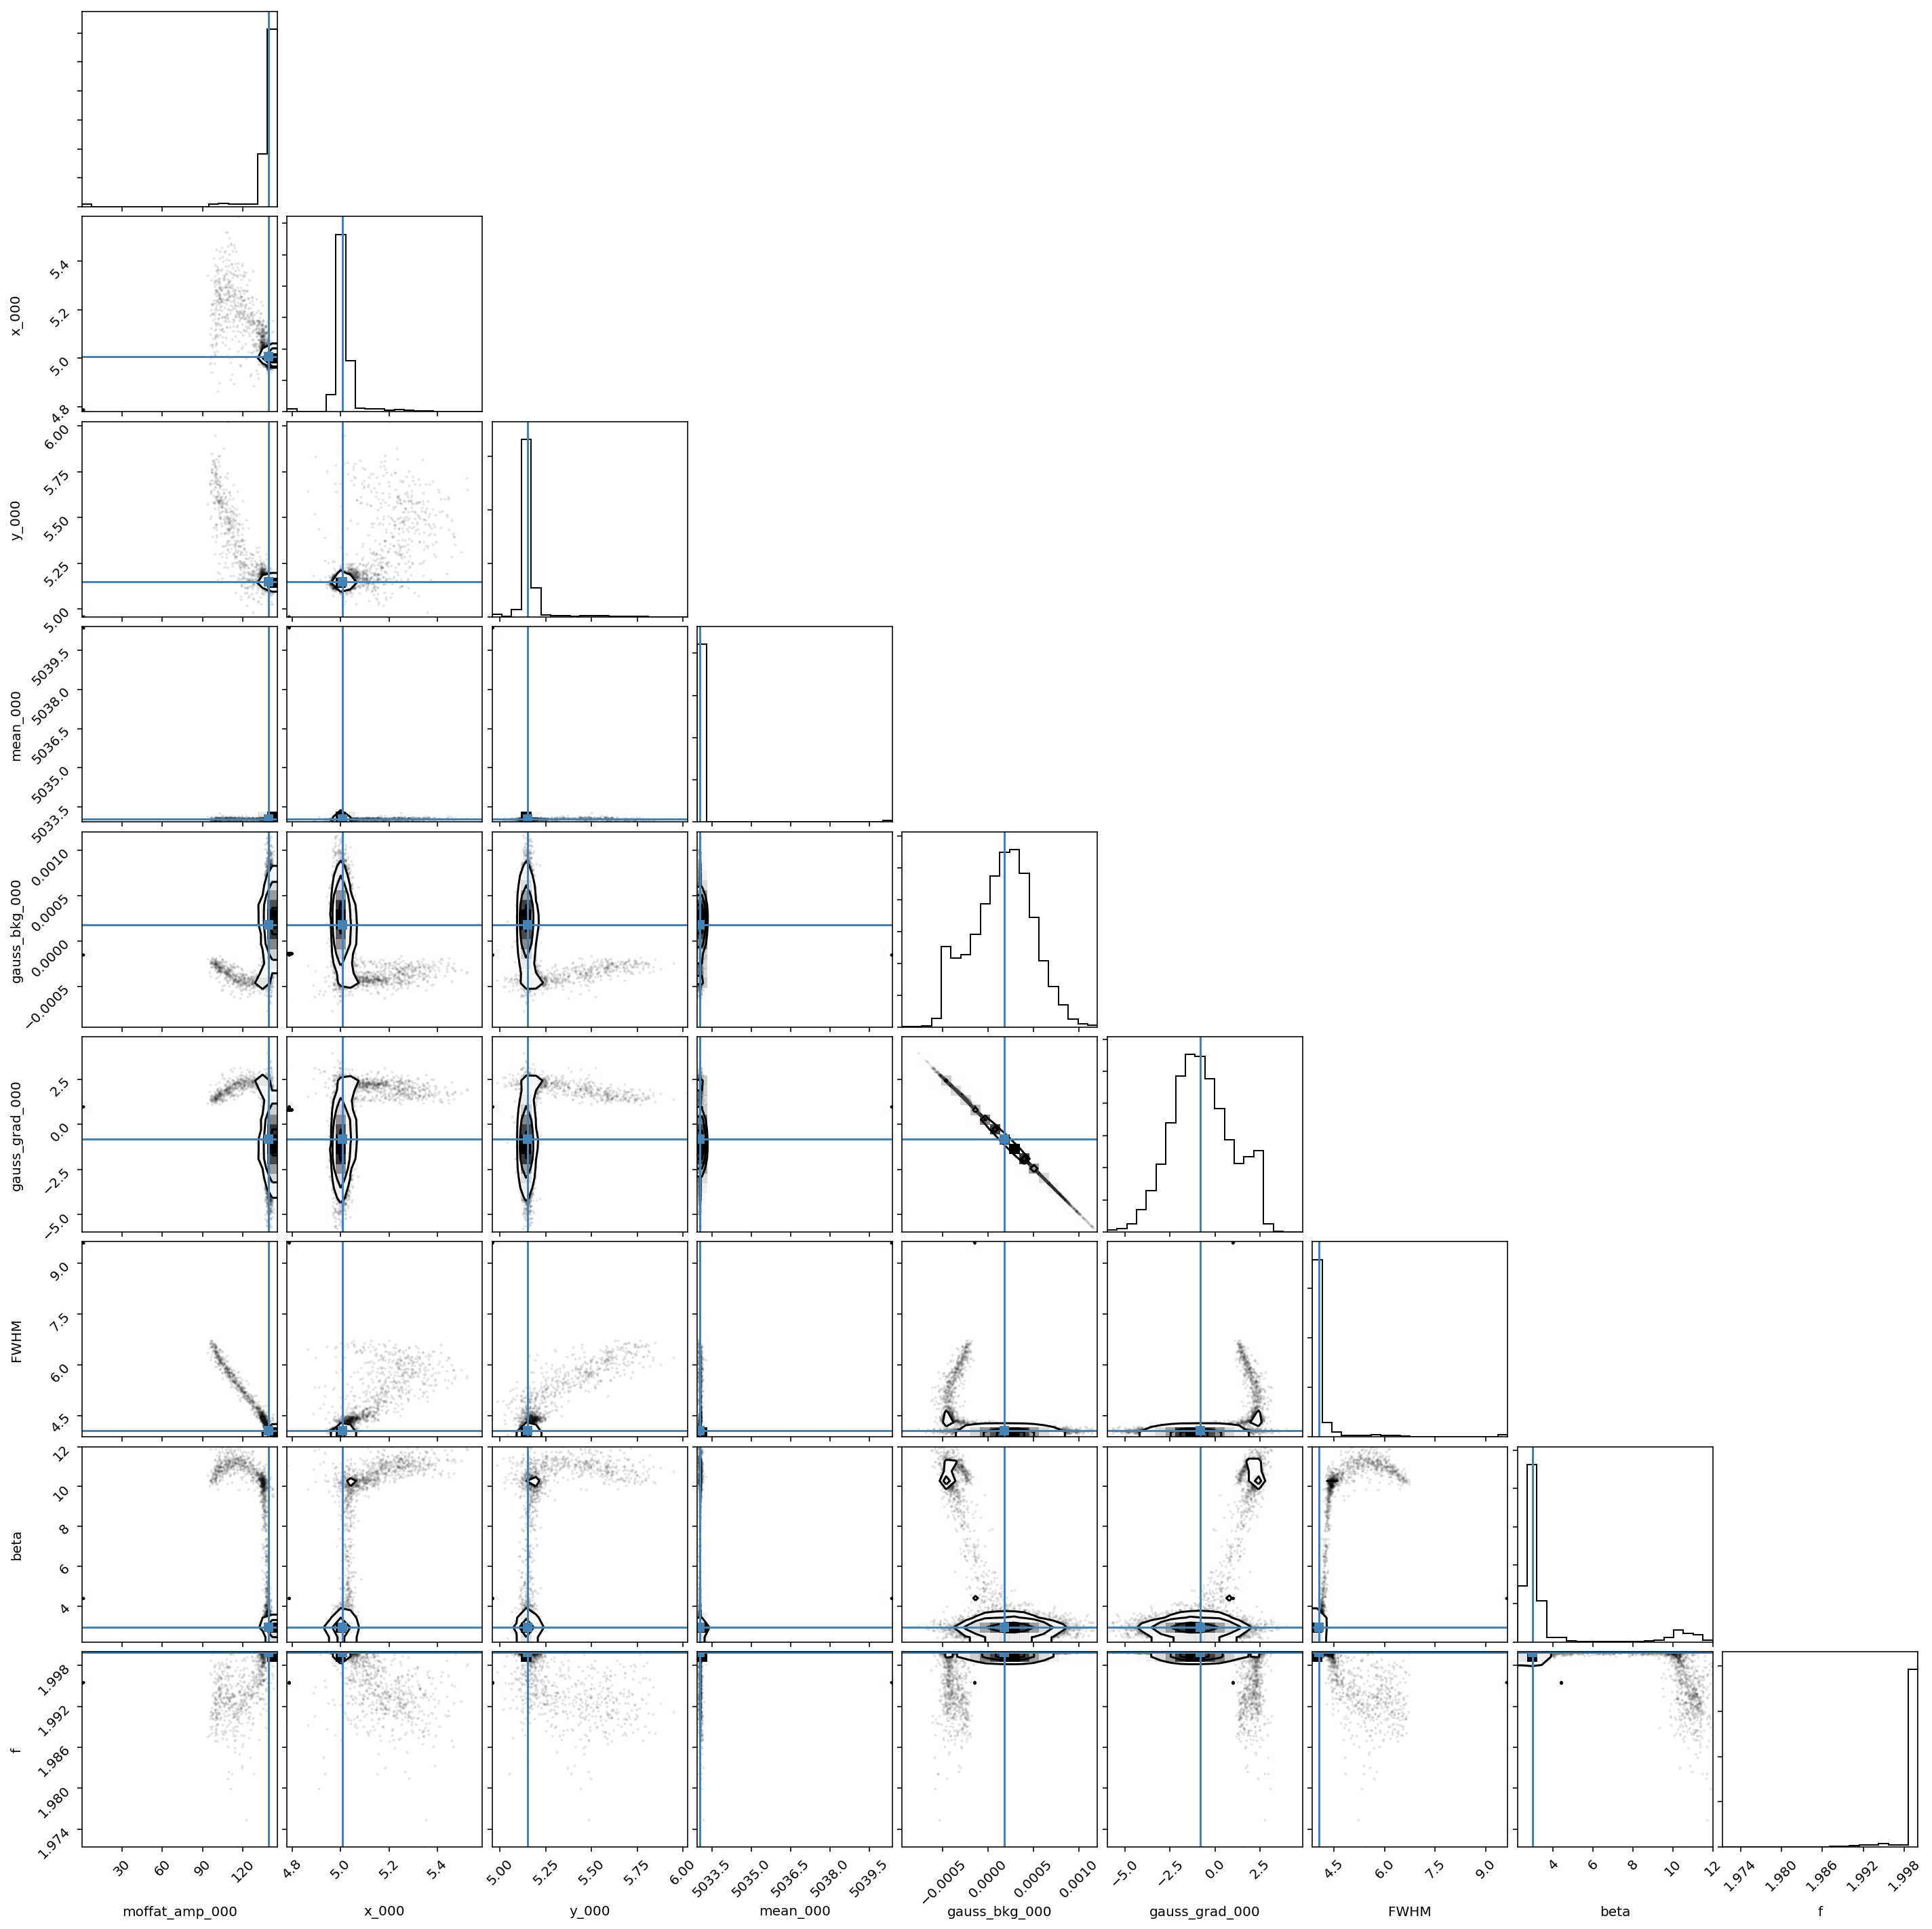

In [5]:
a=corner.corner(MCMC_results.flatchain, labels=MCMC_results.var_names, truths=list(MCMC_results.params.valuesdict().values()))
